In [1]:
pip install simpy networkx qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 21.8 MB/s eta 0:00:00


In [2]:
import simpy
import networkx as nx
import matplotlib.pyplot as plt
import random
import time

TIME: 0


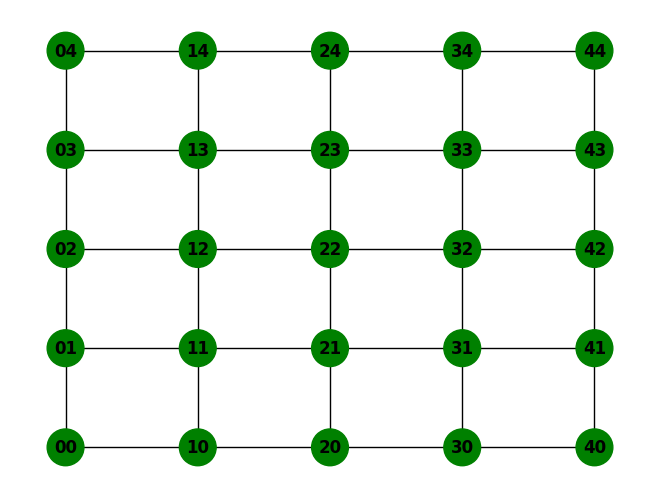

generate communication begin: 0
Time 1: Generating communication from 00 to 40
    Reserving path: ['00', '10', '20', '30', '40']
TIME: 1


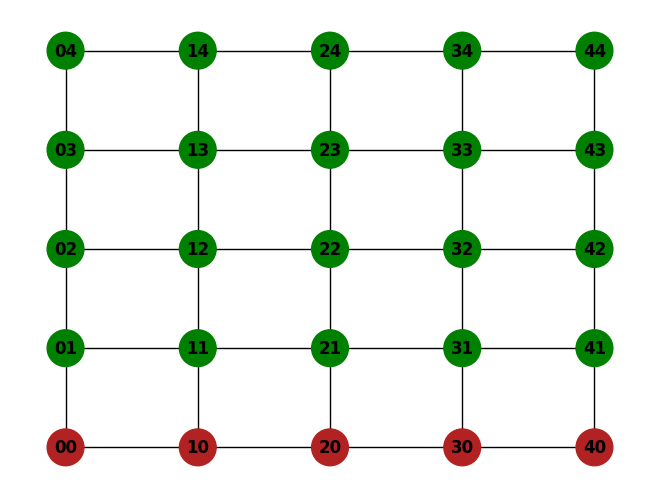

generate communication end: 1
generate communication begin: 1
Time 2: Generating communication from 10 to 24
    No paths available from 10 to 24. Waiting 1 time step.
TIME: 2


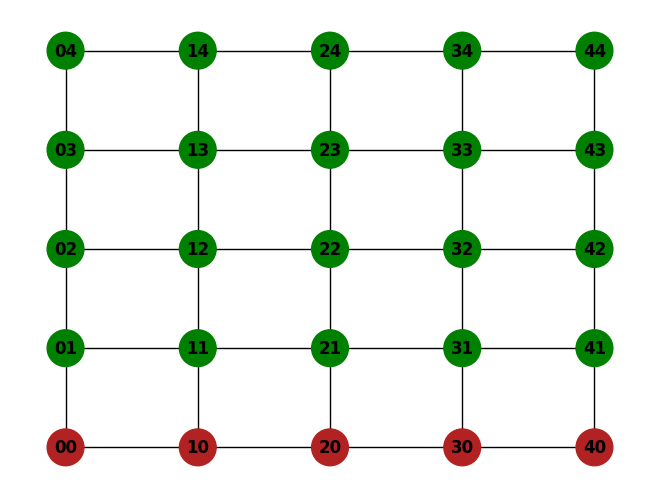

generate communication end: 2
generate communication begin: 2
Time 3: Generating communication from 10 to 24
    No paths available from 10 to 24. Waiting 1 time step.
TIME: 3


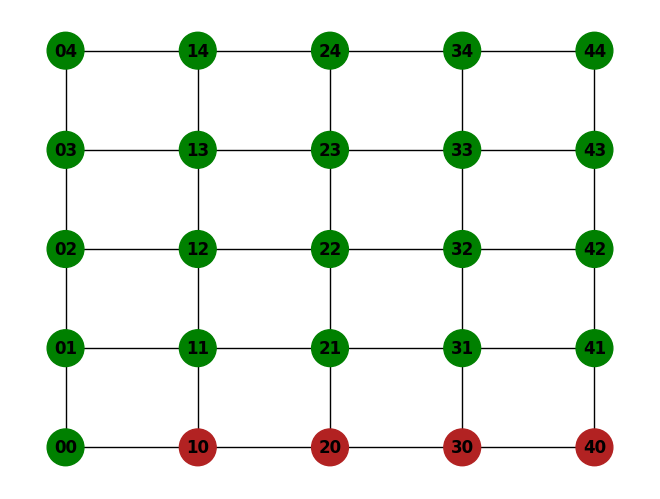

generate communication end: 3
generate communication begin: 3
Time 4: Generating communication from 10 to 24
    Reserving path: ['10', '11', '21', '22', '23', '24']
TIME: 4


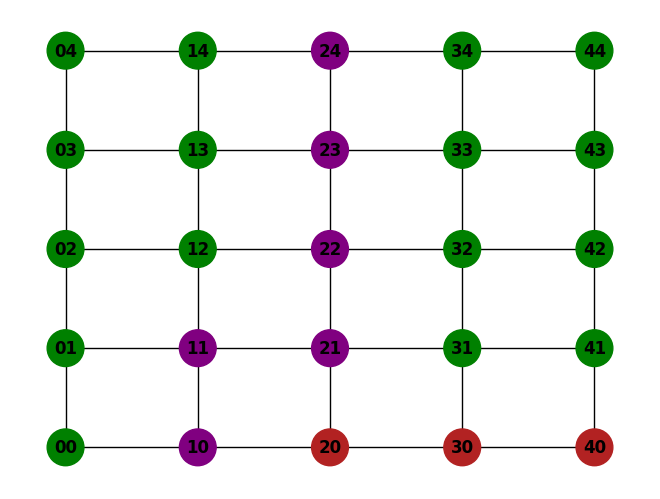

generate communication end: 4
generate communication begin: 4
Time 5: Generating communication from 40 to 14
    No paths available from 40 to 14. Waiting 1 time step.
TIME: 5


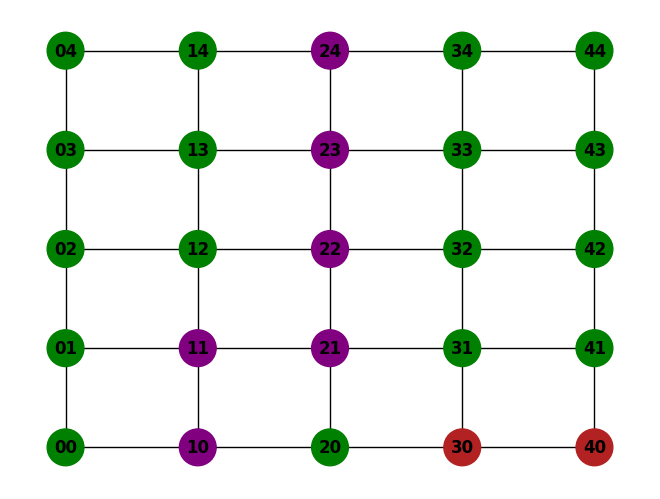

generate communication end: 5
generate communication begin: 5
Time 6: Generating communication from 40 to 14
    No paths available from 40 to 14. Waiting 1 time step.
TIME: 6


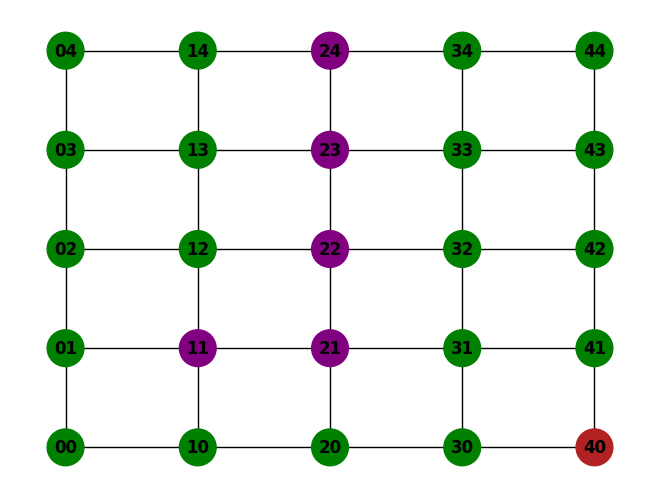

Packet has been delivered from 00 to 40
generate communication end: 6
generate communication begin: 6
Time 7: Generating communication from 40 to 14
    Reserving path: ['40', '30', '20', '10', '11', '12', '13', '14']
TIME: 7


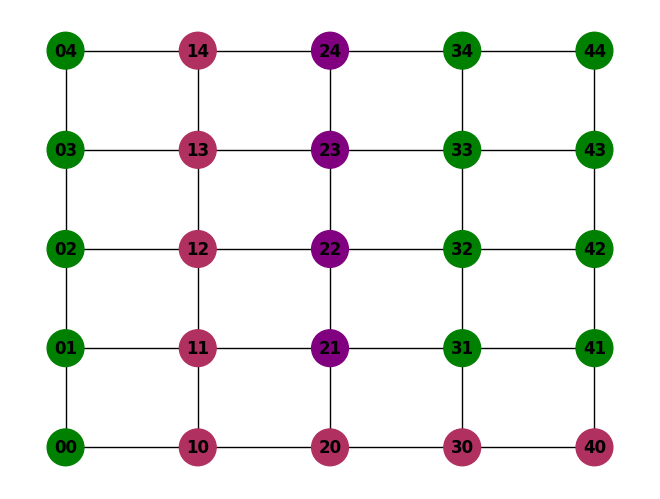

generate communication end: 7
generate communication begin: 7
Time 8: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 8


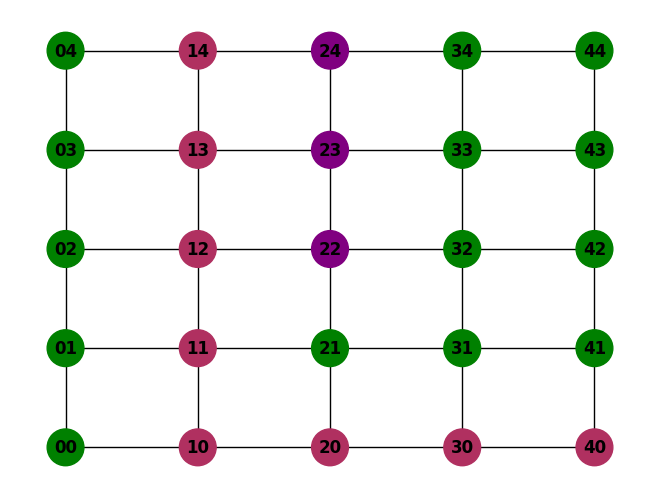

generate communication end: 8
generate communication begin: 8
Time 9: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 9


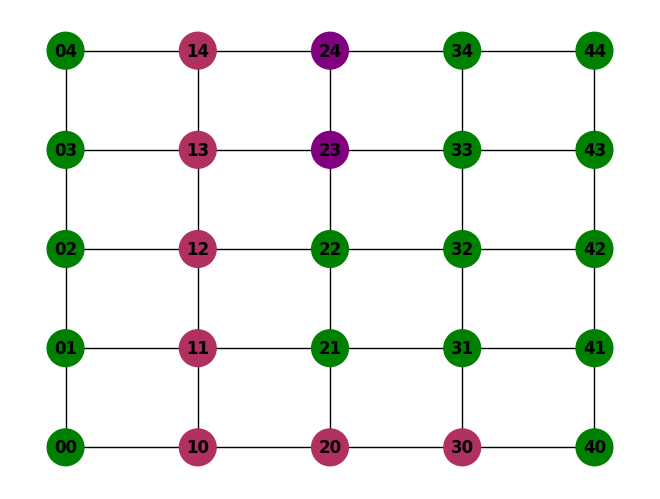

generate communication end: 9
generate communication begin: 9
Time 10: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 10


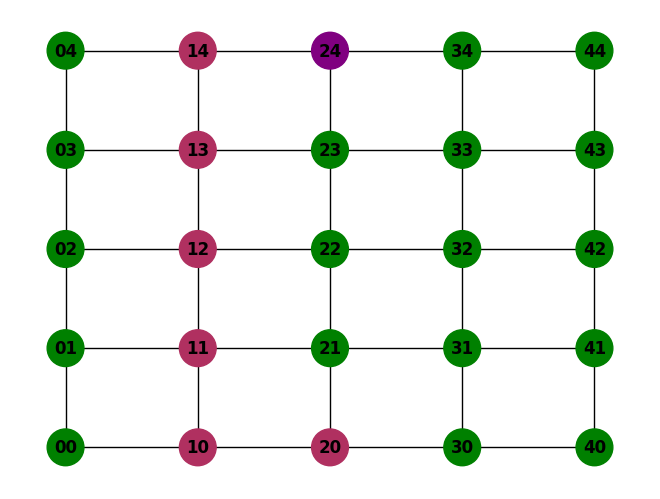

Packet has been delivered from 10 to 24
generate communication end: 10
generate communication begin: 10
Time 11: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 11


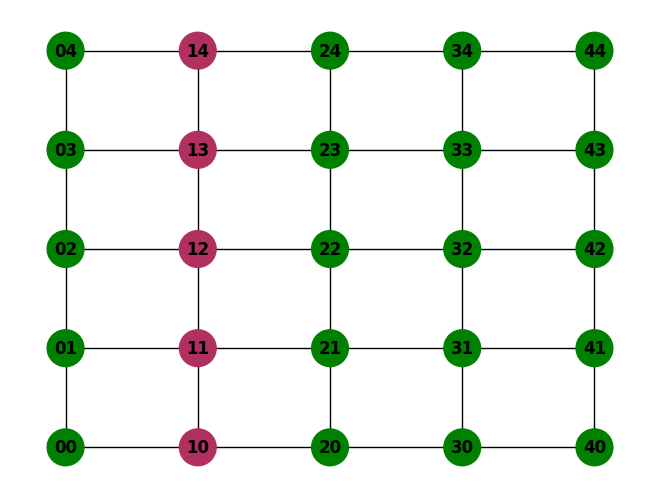

generate communication end: 11
generate communication begin: 11
Time 12: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 12


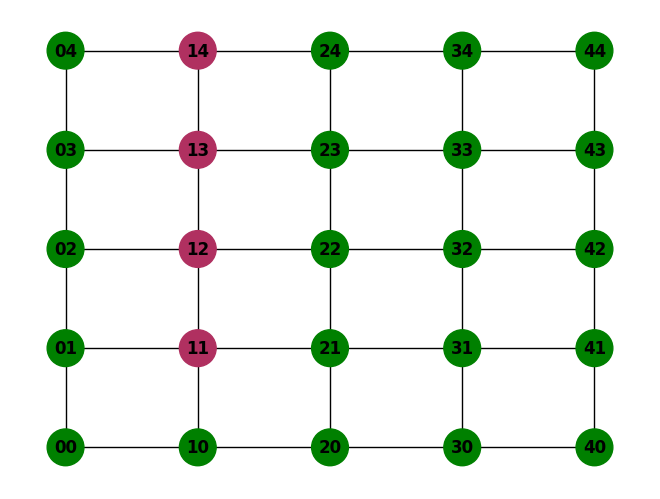

generate communication end: 12
generate communication begin: 12
Time 13: Generating communication from 04 to 41
    Reserving path: ['04', '03', '02', '01', '11', '21', '31', '41']
TIME: 13


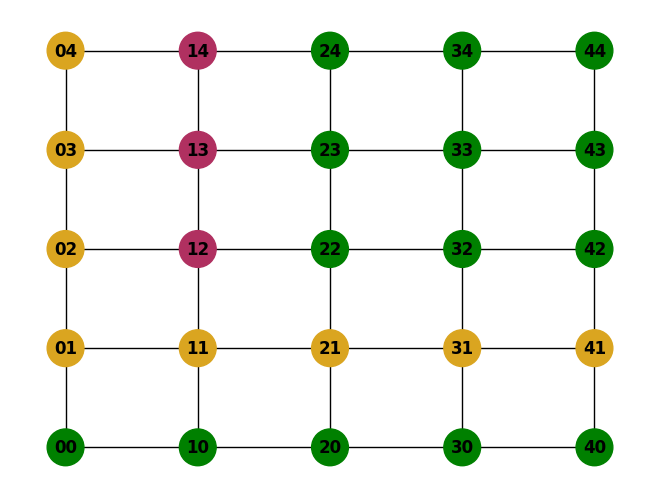

generate communication end: 13
generate communication begin: 13
Time 14: Generating communication from 30 to 44
    No paths available from 30 to 44. Waiting 1 time step.
TIME: 14


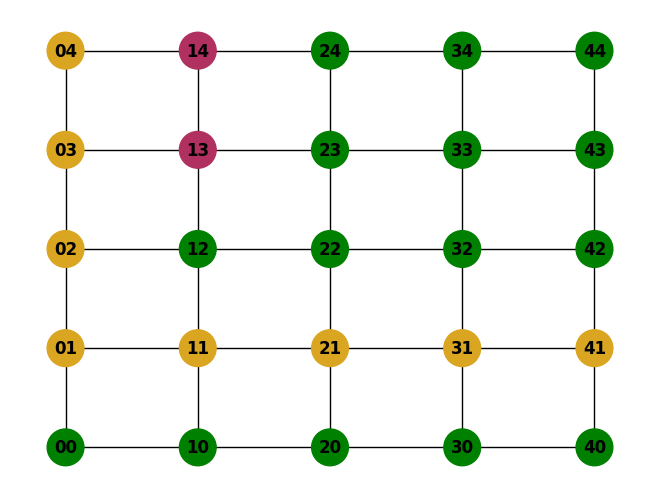

generate communication end: 14
generate communication begin: 14


In [6]:
def create_grid_network(grid_size):
    """
    Create a grid-based network graph with nodes labeled by their coordinates.
    """
    network = nx.Graph()
    for x in range(grid_size):
        for y in range(grid_size):
            node_label = f"{x}{y}"
            network.add_node(node_label)
    for x in range(grid_size):
        for y in range(grid_size):
            node_label = f"{x}{y}"
            if x < grid_size - 1:
                right_node = f"{x+1}{y}"
                network.add_edge(node_label, right_node)
            if y < grid_size - 1:
                below_node = f"{x}{y+1}"
                network.add_edge(node_label, below_node)
    return network

def initialize_node_status(network):
    """
    Initialize the status of nodes in the network as 'free'.
    """
    return {node: 'free' for node in network.nodes()}

def plot_network(G, node_statuses, grid_size, shades_of_red):
    """
    Plot the network with nodes colored based on their status.
    This function is called once per time step to reflect all changes.
    """
    pos = {f"{x}{y}": (x, y) for x in range(grid_size) for y in range(grid_size)}
    colors = []

    for node in G.nodes():
        if node_statuses[node] == 'free':
            colors.append('green')
        else:
            colors.append(shades_of_red[node_statuses[node]])  # Use the shade assigned to the communication

    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
    plt.show()

def is_path_free(path, node_statuses):
    """
    Check if all nodes in the path are free.
    """
    return all(node_statuses[node] == 'free' for node in path)

def reserve_path(path, node_statuses, communication_id):
    """
    Reserve the path by marking all nodes as 'busy' with a specific shade of red.
    """
    for node in path:
        node_statuses[node] = communication_id  # Store the communication ID

def free_path(node, node_statuses):
    """
    Free a single node by marking it as 'free'.
    """
    node_statuses[node] = 'free'

def move_packet(env, path, node_statuses, grid_size, source, target, shades_of_red):
    """
    Move a packet along a path one step at a time, freeing nodes as it moves.
    This process allows multiple packets to move simultaneously in the network.
    """
    for i in range(len(path)):
        if i > 0:
            free_path(path[i-1], node_statuses)
        yield env.timeout(1)  # Each step takes 1 time unit


    free_path(path[-1], node_statuses)
    print(f"Packet has been delivered from {source} to {target}")

def communication_manager(env, network, node_statuses, grid_size, communication_queue, shades_of_red):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            # Sort by start_time to give priority to the longest waiting communication
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]  # Peek at the highest priority task

            all_paths = list(nx.all_shortest_paths(network, source=current_source, target=current_target))
            print(f"Time {env.now}: Generating communication from {current_source} to {current_target}")
            path_reserved = False

            for path in all_paths:
                #print(f"    Testing path {path}")
                if is_path_free(path, node_statuses):
                    print(f"    Reserving path: {path}")
                    reserve_path(path, node_statuses, current_id)
                    env.process(move_packet(env, path, node_statuses, grid_size, current_source, current_target, shades_of_red))  # Start moving the packet
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)  # Only remove the task if the path was successfully reserved
            else:
                print(f"    No paths available from {current_source} to {current_target}. Waiting 1 time step.")
                # Do not remove the communication attempt; leave it in the queue for re-evaluation next time step
        print(f"TIME: {env.now}")
        plot_network(network, node_statuses, grid_size, shades_of_red)  # Plot the network once per time step
        yield env.timeout(1)  # Wait one time step before processing the next communication

def communicate(env, network, source, target, node_statuses, grid_size, communication_queue, communication_id):
    """
    Queue a communication attempt.
    """
    communication_queue.append((env.now, source, target, communication_id))

def generate_communications(env, network, node_statuses, grid_size, communication_queue, shades_of_red):
    """
    Generate communication attempts between nodes on opposite sides of the grid.
    """
    left_side = [f"0{y}" for y in range(grid_size)]
    right_side = [f"{grid_size-1}{y}" for y in range(grid_size)]
    top_side = [f"{x}0" for x in range(grid_size)]
    bottom_side = [f"{x}{grid_size-1}" for x in range(grid_size)]
    communication_id = 0

    while True:
        if random.choice([True, False]):
            source = random.choice(left_side)
            target = random.choice(right_side)
        else:
            source = random.choice(top_side)
            target = random.choice(bottom_side)

        if source != target:
            communicate(env, network, source, target, node_statuses, grid_size, communication_queue, communication_id)
            communication_id = (communication_id + 1) % len(shades_of_red)  # Cycle through available colors
        print(f"generate communication begin: {env.now}")
        yield env.timeout(1)  # Wait for the next time step
        print(f"generate communication end: {env.now}")


# Main execution
grid_size = 5
random.seed(2)

# Create and connect the grid network
network = create_grid_network(grid_size)

# Initialize node statuses
node_statuses = initialize_node_status(network)

# Generate different shades of red for communications
shades_of_red = ["#B22222","#800080", "#B03060", "#DAA520", "#BC8F8F"]

# Create the simulation environment
env = simpy.Environment()

# List to store communication attempts with priority management
communication_queue = []

# Start the communication manager
env.process(communication_manager(env, network, node_statuses, grid_size, communication_queue, shades_of_red))

# Generate communication attempts in the network between opposite sides
env.process(generate_communications(env, network, node_statuses, grid_size, communication_queue, shades_of_red))

# Run the simulation
env.run(until=15)  # Run the simulation for 15 time steps


TIME: 0


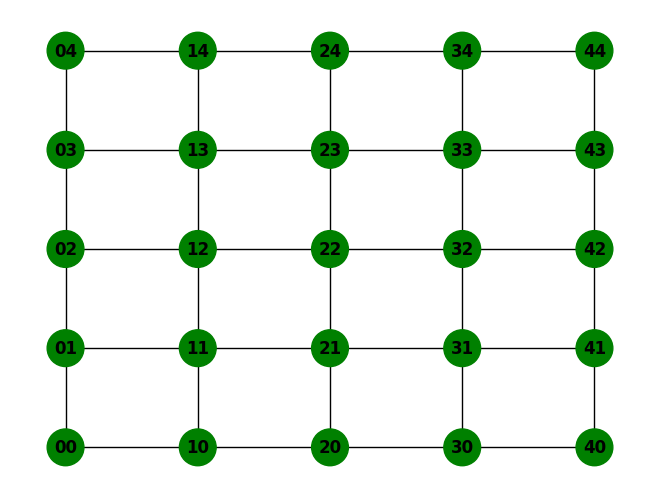

generate communication begin: 0
Time 1: Generating communication from 00 to 40
    Reserving path: ['00', '10', '20', '30', '40']
TIME: 1


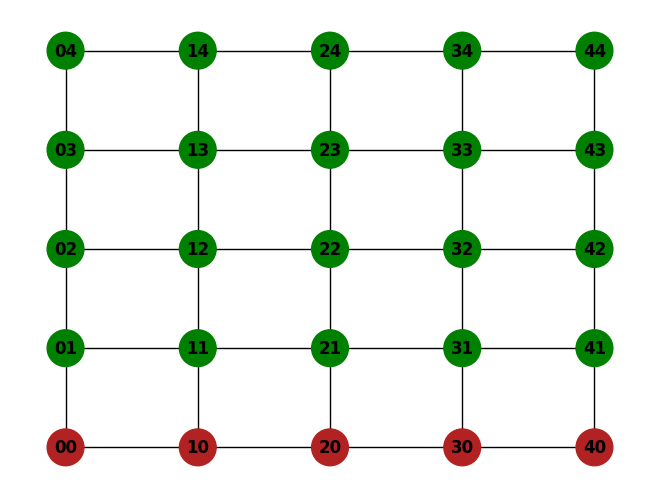

generate communication end: 1
generate communication begin: 1
Time 2: Generating communication from 10 to 24
    No paths available from 10 to 24. Waiting 1 time step.
TIME: 2


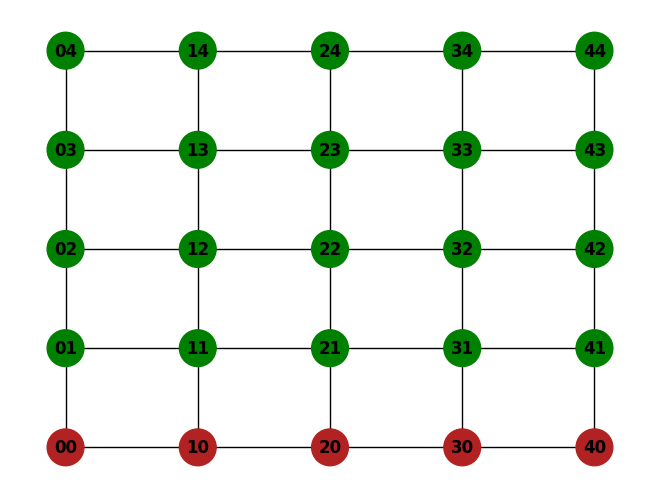

generate communication end: 2
generate communication begin: 2
Time 3: Generating communication from 10 to 24
    No paths available from 10 to 24. Waiting 1 time step.
TIME: 3


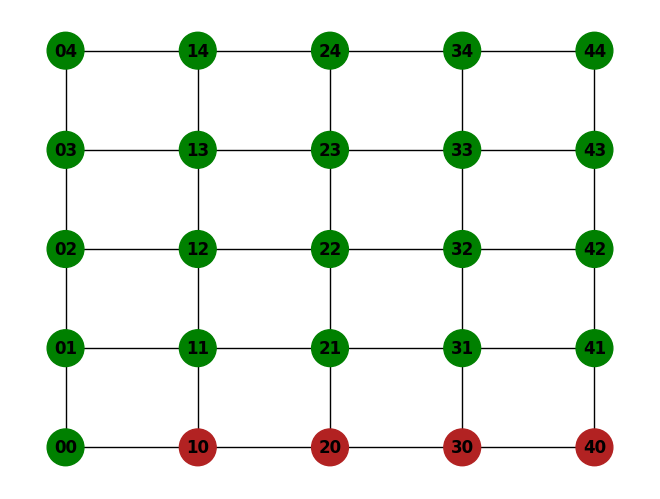

generate communication end: 3
generate communication begin: 3
Time 4: Generating communication from 10 to 24
    Reserving path: ['10', '11', '21', '22', '23', '24']
TIME: 4


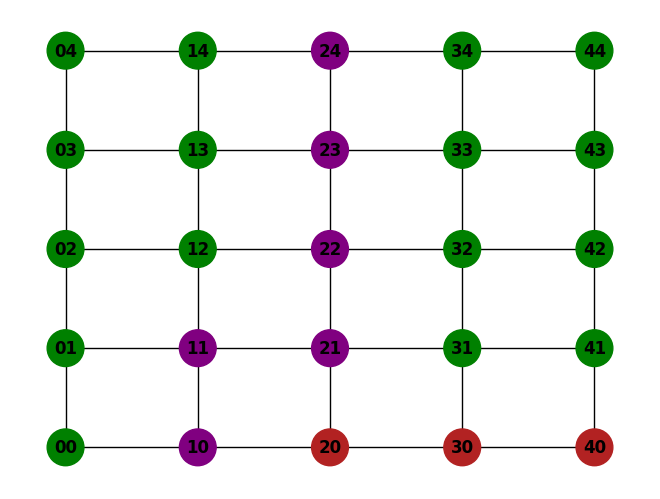

generate communication end: 4
generate communication begin: 4
Time 5: Generating communication from 40 to 14
    No paths available from 40 to 14. Waiting 1 time step.
TIME: 5


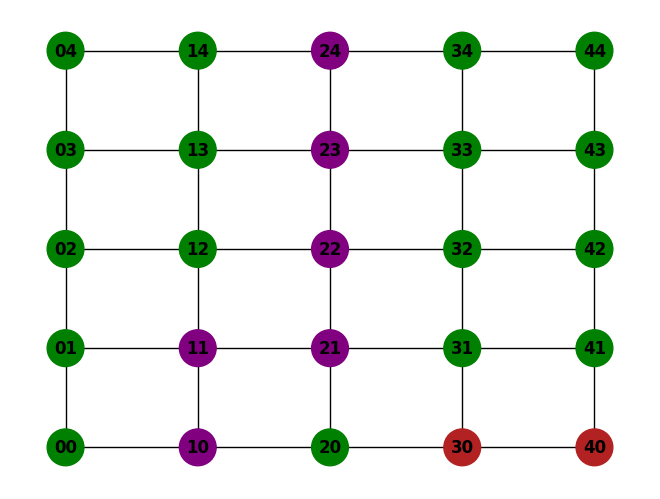

Packet 0 has been delivered along path ['00', '10', '20', '30', '40']
generate communication end: 5
generate communication begin: 5
Time 6: Generating communication from 40 to 14
    No paths available from 40 to 14. Waiting 1 time step.
TIME: 6


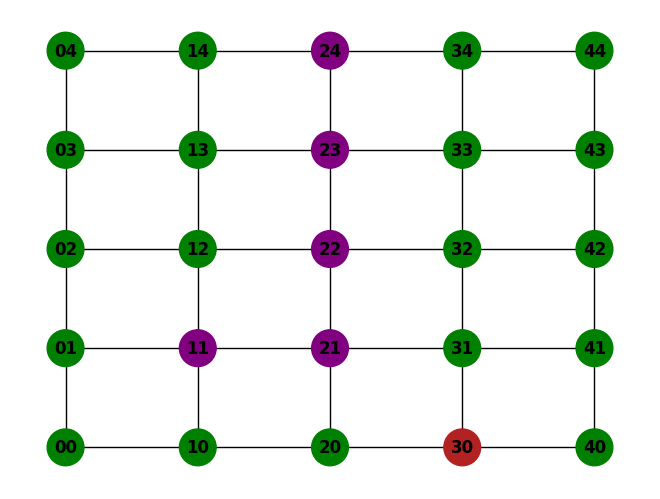

generate communication end: 6
generate communication begin: 6
Time 7: Generating communication from 40 to 14
    No paths available from 40 to 14. Waiting 1 time step.
TIME: 7


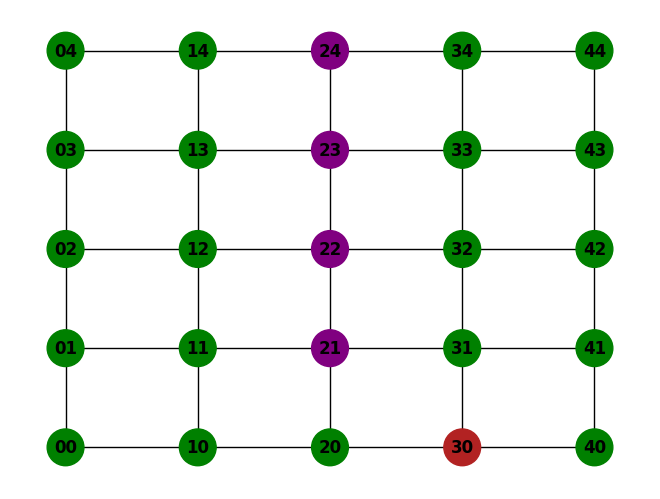

generate communication end: 7
generate communication begin: 7
Time 8: Generating communication from 40 to 14
    Reserving path: ['40', '41', '31', '21', '11', '12', '13', '14']
TIME: 8


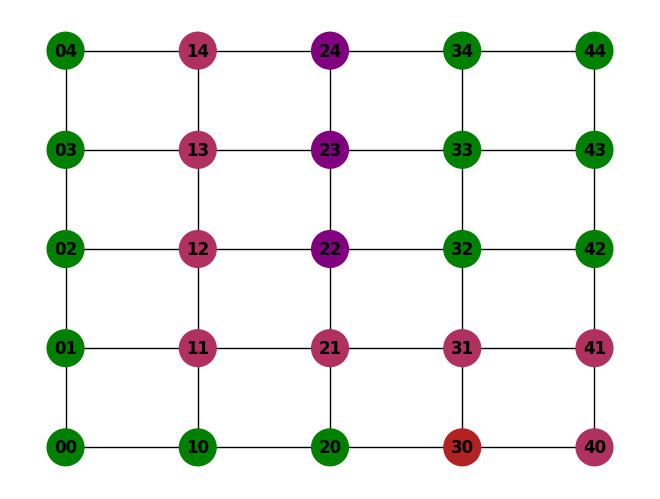

generate communication end: 8
generate communication begin: 8
Time 9: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 9


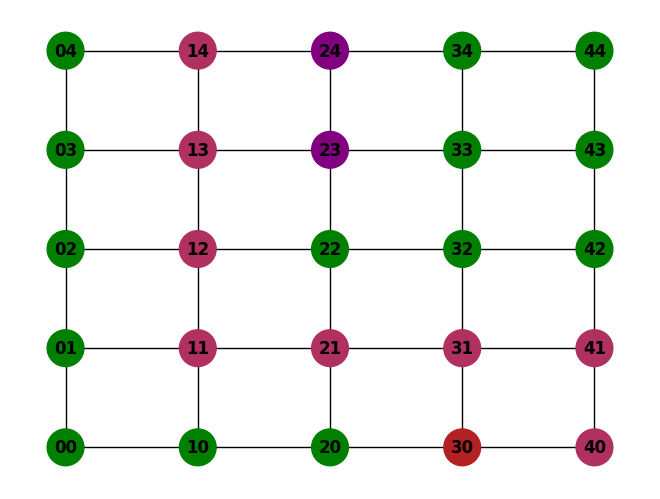

Packet 1 has been delivered along path ['10', '11', '21', '22', '23', '24']
generate communication end: 9
generate communication begin: 9
Time 10: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 10


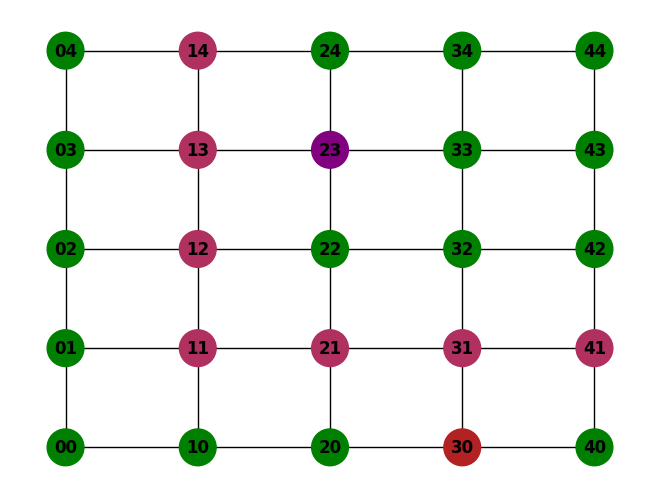

generate communication end: 10
generate communication begin: 10
Time 11: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 11


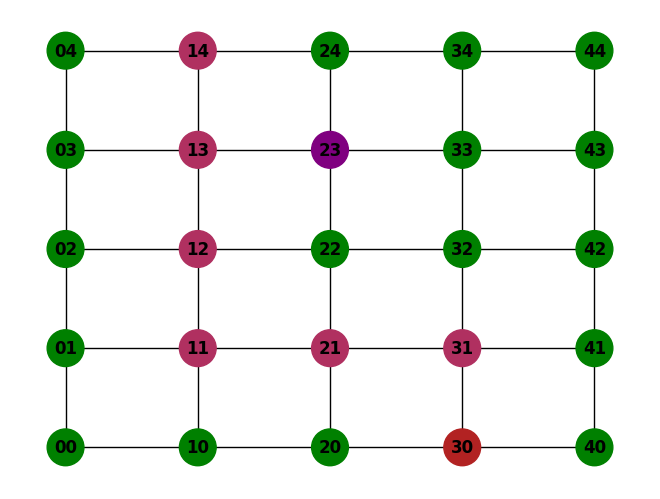

generate communication end: 11
generate communication begin: 11
Time 12: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 12


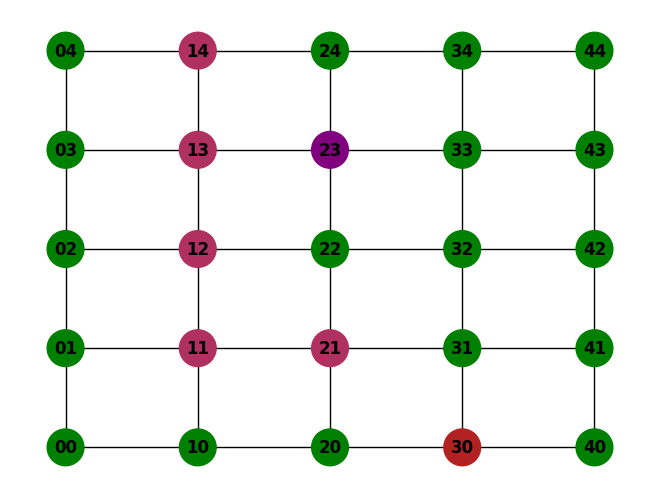

generate communication end: 12
generate communication begin: 12
Time 13: Generating communication from 04 to 41
    No paths available from 04 to 41. Waiting 1 time step.
TIME: 13


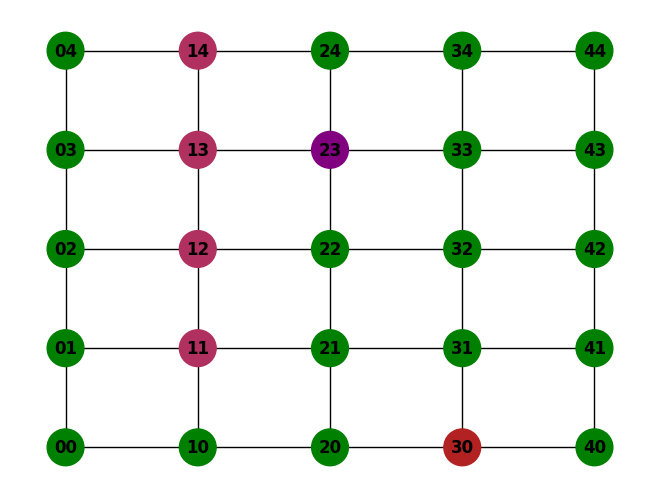

generate communication end: 13
generate communication begin: 13
Time 14: Generating communication from 04 to 41
    Reserving path: ['04', '03', '02', '01', '11', '21', '31', '41']
TIME: 14


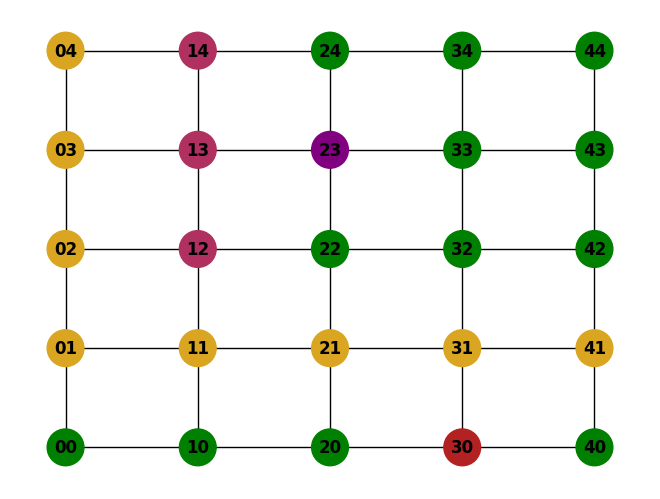

generate communication end: 14
generate communication begin: 14


In [9]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt

class Communication:
    def __init__(self, communication_id, path):
        self.communication_id = communication_id
        self.path = path
        self.current_node_index = 0
        self.time_elapsed = 0

    def advance(self):
        """
        Move the communication to the next node in the path.
        """
        if self.current_node_index < len(self.path) - 1:
            self.current_node_index += 1

    def current_node(self):
        """
        Get the current node in the path.
        """
        return self.path[self.current_node_index]

    def is_complete(self):
        """
        Check if the communication has reached its target.
        """
        return self.current_node_index == len(self.path) - 1

def create_grid_network(grid_size):
    """
    Create a grid-based network graph with nodes labeled by their coordinates.
    """
    network = nx.Graph()
    for x in range(grid_size):
        for y in range(grid_size):
            node_label = f"{x}{y}"
            network.add_node(node_label)
    for x in range(grid_size):
        for y in range(grid_size):
            node_label = f"{x}{y}"
            if x < grid_size - 1:
                right_node = f"{x+1}{y}"
                network.add_edge(node_label, right_node)
            if y < grid_size - 1:
                below_node = f"{x}{y+1}"
                network.add_edge(node_label, below_node)
    return network

def initialize_node_status(network):
    """
    Initialize the status of nodes in the network as 'free'.
    """
    return {node: 'free' for node in network.nodes()}

def plot_network(G, node_statuses, grid_size, shades_of_red):
    """
    Plot the network with nodes colored based on their status.
    This function is called once per time step to reflect all changes.
    """
    pos = {f"{x}{y}": (x, y) for x in range(grid_size) for y in range(grid_size)}
    colors = []

    for node in G.nodes():
        if node_statuses[node] == 'free':
            colors.append('green')
        else:
            colors.append(shades_of_red[node_statuses[node]])  # Use the shade assigned to the communication

    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
    plt.show()

def is_path_free(path, node_statuses):
    """
    Check if all nodes in the path are free.
    """
    return all(node_statuses[node] == 'free' for node in path)

def reserve_path(path, node_statuses, communication):
    """
    Reserve the path by marking all nodes as 'busy' with a specific shade of red.
    """
    for node in path:
        node_statuses[node] = communication.communication_id  # Store the communication ID

def free_path(node, node_statuses):
    """
    Free a single node by marking it as 'free'.
    """
    node_statuses[node] = 'free'

def move_packet(env, communication, node_statuses):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    This process allows multiple packets to move simultaneously in the network.
    """
    while not communication.is_complete():
        # Advance communication forward in Communication object
        communication.advance()

        current_node = communication.current_node()
        if communication.current_node_index > 0:
            previous_node = communication.path[communication.current_node_index - 1]
            free_path(previous_node, node_statuses)

        yield env.timeout(1)  # Each step takes 1 time unit
        communication.time_elapsed += 1

    free_path(communication.path[-1], node_statuses)
    print(f"Packet {communication.communication_id} has been delivered along path {communication.path}")

def communication_manager(env, network, node_statuses, grid_size, communication_queue, shades_of_red):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            # Sort by start_time to give priority to the longest waiting communication
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]  # Peek at the highest priority task

            all_paths = list(nx.all_shortest_paths(network, source=current_source, target=current_target))
            print(f"Time {env.now}: Generating communication from {current_source} to {current_target}")
            path_reserved = False

            for path in all_paths:
                if is_path_free(path, node_statuses):
                    print(f"    Reserving path: {path}")
                    communication = Communication(current_id, path)
                    reserve_path(path, node_statuses, communication)
                    env.process(move_packet(env, communication, node_statuses))  # Start moving the packet
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)  # Only remove the task if the path was successfully reserved
            else:
                print(f"    No paths available from {current_source} to {current_target}. Waiting 1 time step.")
                # Do not remove the communication attempt; leave it in the queue for re-evaluation next time step
        print(f"TIME: {env.now}")
        plot_network(network, node_statuses, grid_size, shades_of_red)  # Plot the network once per time step
        yield env.timeout(1)  # Wait one time step before processing the next communication

def communicate(env, network, source, target, node_statuses, grid_size, communication_queue, communication_id):
    """
    Queue a communication attempt.
    """
    communication_queue.append((env.now, source, target, communication_id))

def generate_communications(env, network, node_statuses, grid_size, communication_queue, shades_of_red):
    """
    Generate communication attempts between nodes on opposite sides of the grid.
    """
    left_side = [f"0{y}" for y in range(grid_size)]
    right_side = [f"{grid_size-1}{y}" for y in range(grid_size)]
    top_side = [f"{x}0" for x in range(grid_size)]
    bottom_side = [f"{x}{grid_size-1}" for x in range(grid_size)]
    communication_id = 0

    while True:
        if random.choice([True, False]):
            source = random.choice(left_side)
            target = random.choice(right_side)
        else:
            source = random.choice(top_side)
            target = random.choice(bottom_side)

        if source != target:
            communicate(env, network, source, target, node_statuses, grid_size, communication_queue, communication_id)
            communication_id = (communication_id + 1) % len(shades_of_red)  # Cycle through available colors
        print(f"generate communication begin: {env.now}")
        yield env.timeout(1)  # Wait for the next time step
        print(f"generate communication end: {env.now}")


# Main execution
grid_size = 5
random.seed(2)

# Create and connect the grid network
network = create_grid_network(grid_size)

# Initialize node statuses
node_statuses = initialize_node_status(network)

# Generate different shades of red for communications
shades_of_red = ["#B22222","#800080", "#B03060", "#DAA520", "#BC8F8F"]

# Create the simulation environment
env = simpy.Environment()

# List to store communication attempts with priority management
communication_queue = []

# Start the communication manager
env.process(communication_manager(env, network, node_statuses, grid_size, communication_queue, shades_of_red))

# Generate communication attempts in the network between opposite sides
env.process(generate_communications(env, network, node_statuses, grid_size, communication_queue, shades_of_red))

# Run the simulation
env.run(until=15)  # Run the simulation for 15 time steps


generate communication begin: 0
generate communication end: 1
generate communication begin: 1


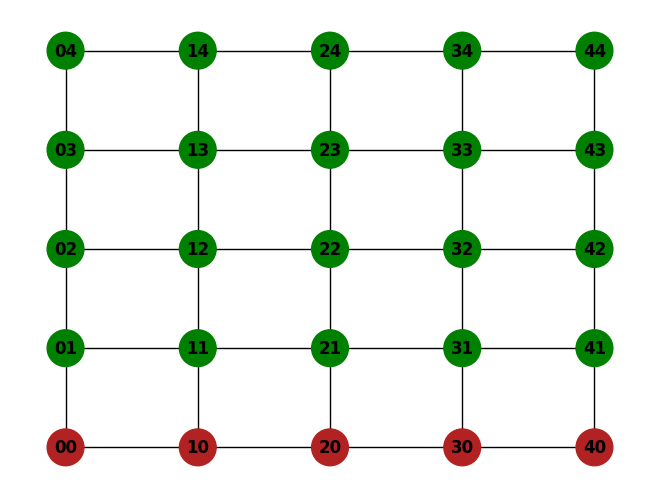

Time 2: Node 00 is freed.
generate communication end: 2
generate communication begin: 2


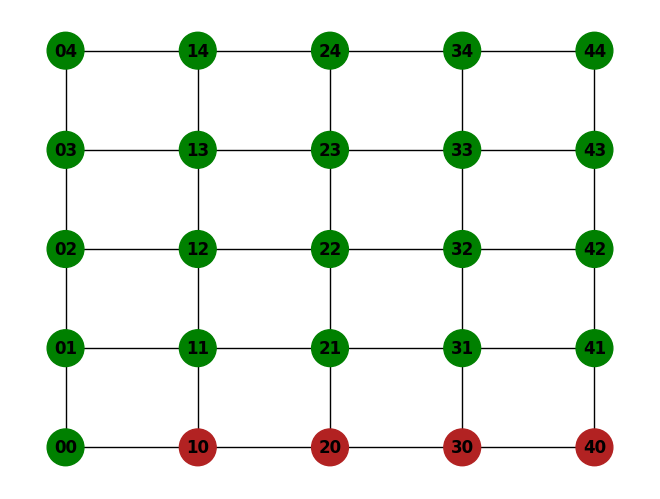

Time 3: Node 10 is freed.
generate communication end: 3
generate communication begin: 3


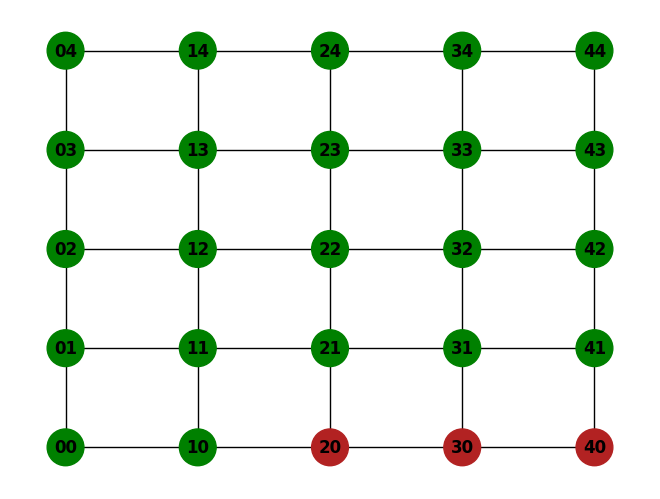

Time 4: Node 20 is freed.
generate communication end: 4
generate communication begin: 4


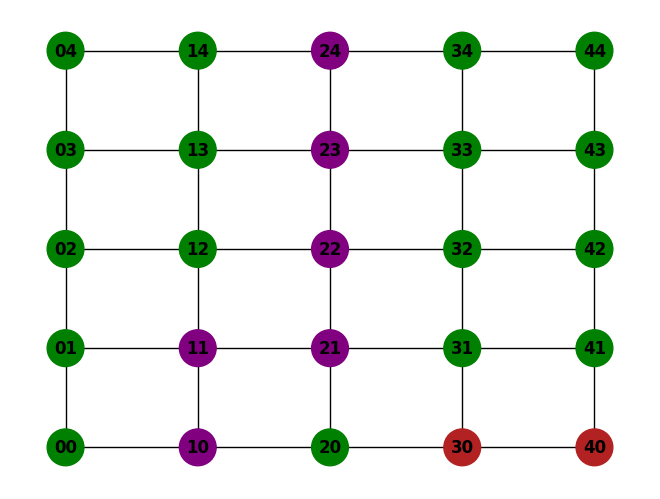

Time 5: Node 10 is freed.
Time 5: Node 30 is freed.
Time 5: Node 40 is freed.
Packet 0 has been delivered along path ['00', '10', '20', '30', '40']
generate communication end: 5
generate communication begin: 5


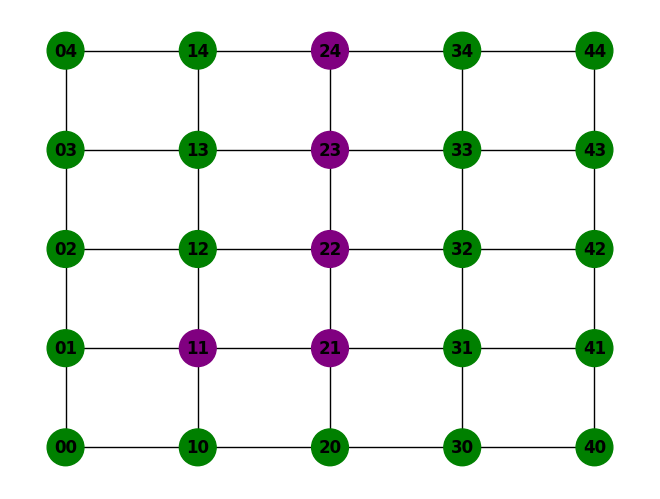

Time 6: Node 11 is freed.
generate communication end: 6
generate communication begin: 6


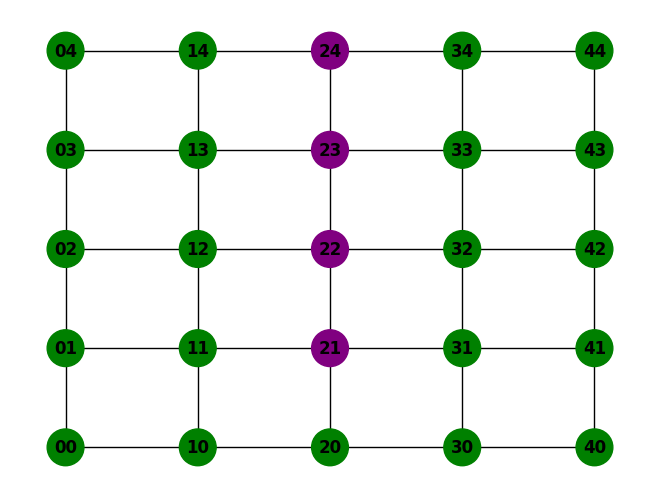

Time 7: Node 21 is freed.
generate communication end: 7
generate communication begin: 7


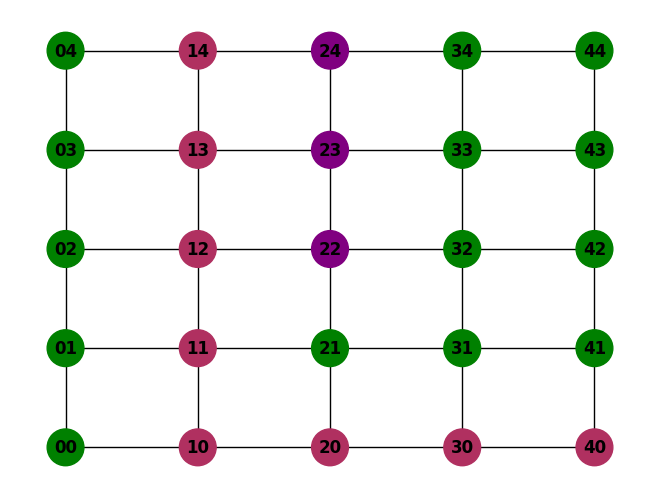

Time 8: Node 40 is freed.
Time 8: Node 22 is freed.
generate communication end: 8
generate communication begin: 8


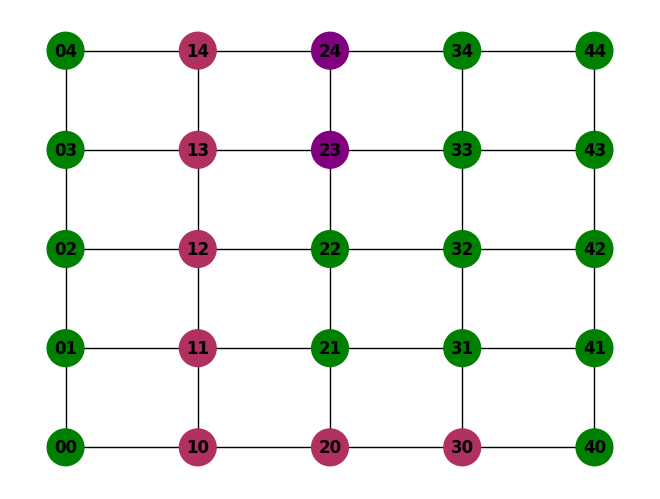

Time 9: Node 30 is freed.
Time 9: Node 23 is freed.
Time 9: Node 24 is freed.
Packet 1 has been delivered along path ['10', '11', '21', '22', '23', '24']
generate communication end: 9
generate communication begin: 9


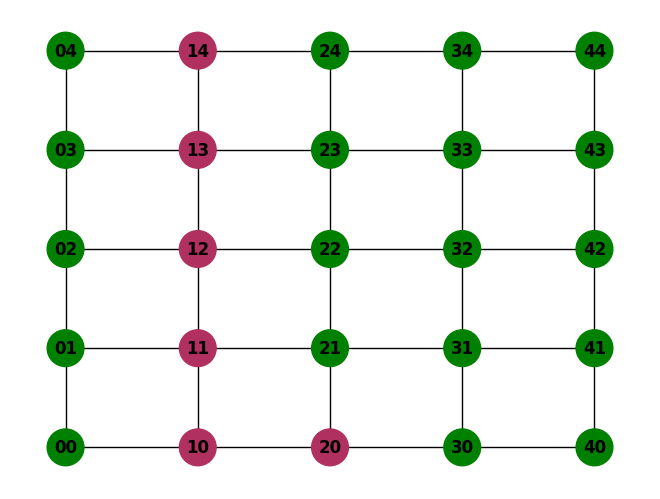

Time 10: Node 20 is freed.
generate communication end: 10
generate communication begin: 10


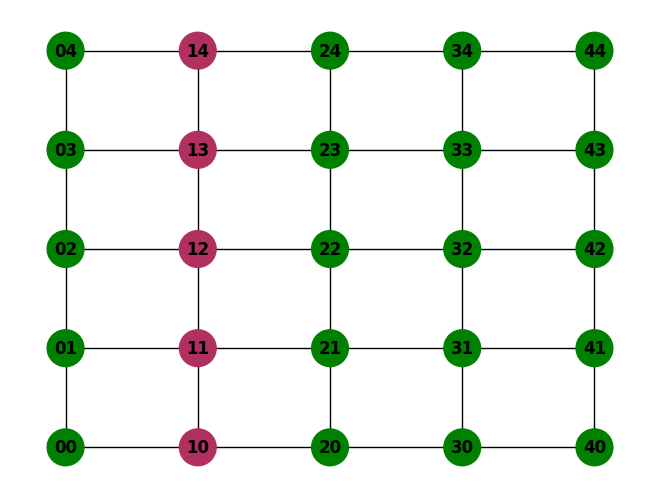

Time 11: Node 10 is freed.
generate communication end: 11
generate communication begin: 11


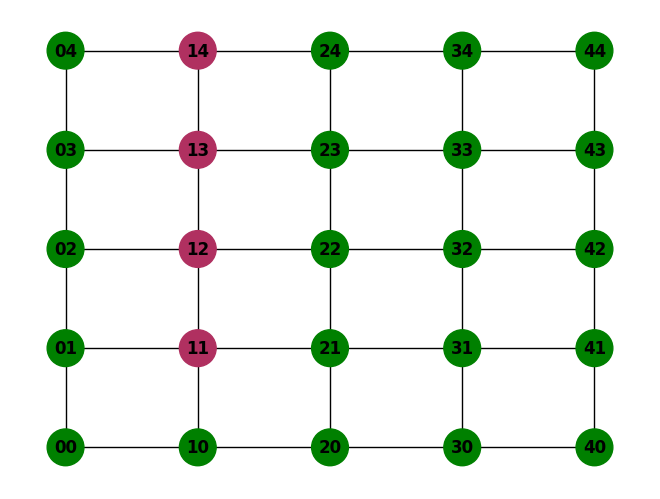

Time 12: Node 11 is freed.
generate communication end: 12
generate communication begin: 12


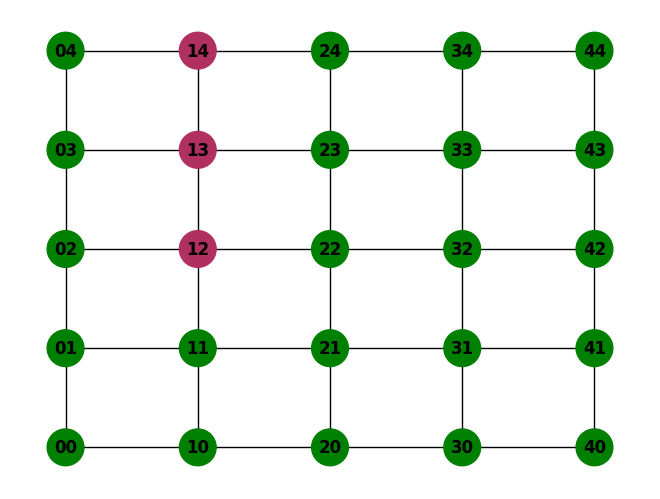

Time 13: Node 12 is freed.
generate communication end: 13
generate communication begin: 13


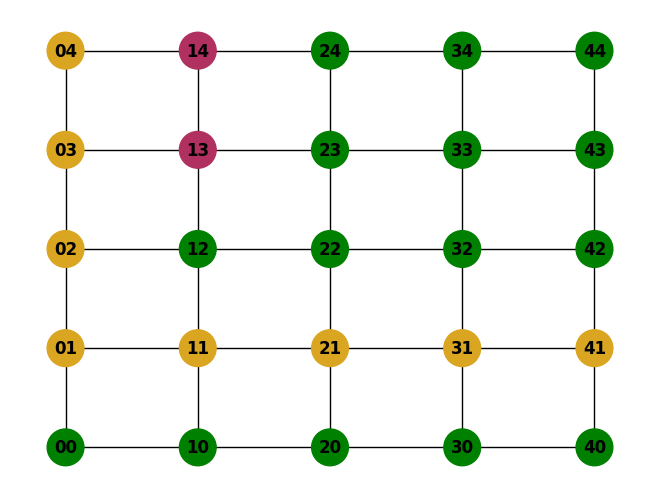

Time 14: Node 04 is freed.
Time 14: Node 13 is freed.
Time 14: Node 14 is freed.
Packet 2 has been delivered along path ['40', '30', '20', '10', '11', '12', '13', '14']
generate communication end: 14
generate communication begin: 14


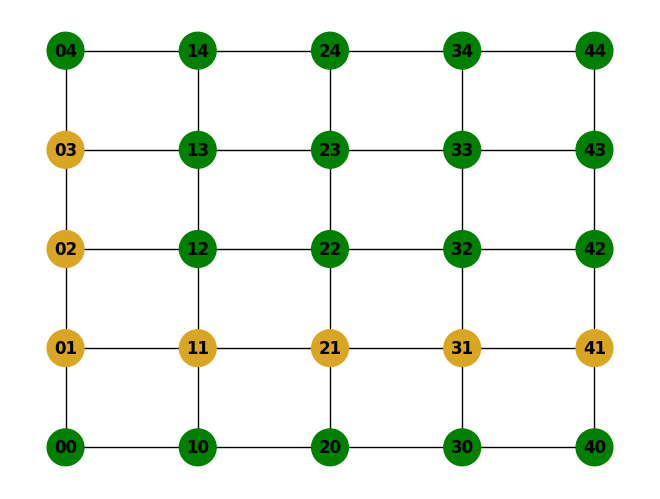

In [14]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt

class Grid:
    def __init__(self, grid_size, env):
        self.grid_size = grid_size
        self.env = env  # Store the simulation environment
        self.network = self.create_grid_network()
        self.node_statuses = self.initialize_node_status()

    def create_grid_network(self):
        """
        Create a grid-based network graph with nodes labeled by their coordinates.
        """
        network = nx.Graph()
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                network.add_node(node_label)
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                if x < self.grid_size - 1:
                    right_node = f"{x+1}{y}"
                    network.add_edge(node_label, right_node)
                if y < self.grid_size - 1:
                    below_node = f"{x}{y+1}"
                    network.add_edge(node_label, below_node)
        return network

    def initialize_node_status(self):
        """
        Initialize the status of nodes in the network as 'free'.
        """
        return {node: 'free' for node in self.network.nodes()}

    def plot_network(self, shades_of_red):
        """
        Plot the network with nodes colored based on their status.
        """
        pos = {f"{x}{y}": (x, y) for x in range(self.grid_size) for y in range(self.grid_size)}
        colors = []

        for node in self.network.nodes():
            if self.node_statuses[node] == 'free':
                colors.append('green')
            else:
                colors.append(shades_of_red[self.node_statuses[node]])  # Use the shade assigned to the communication

        nx.draw(self.network, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
        plt.show()

    def is_path_free(self, path):
        """
        Check if all nodes in the path are free.
        """
        return all(self.node_statuses[node] == 'free' for node in path)

    def free_node(self, node):
        """
        Free a single node by marking it as 'free' and print the time it was freed.
        """
        self.node_statuses[node] = 'free'
        print(f"Time {self.env.now}: Node {node} is freed.")

    def reserve_path(self, path, communication_id):
        """
        Reserve the path by marking all nodes as 'busy' with the communication ID.
        """
        for node in path:
            self.node_statuses[node] = communication_id

class Communication:
    def __init__(self, communication_id, path, grid):
        self.communication_id = communication_id
        self.path = path
        self.current_node_index = 0
        self.time_elapsed = 0
        self.grid = grid
        self.grid.reserve_path(self.path, self.communication_id % len(shades_of_red)) # cycling through shades of red

    def advance(self):
        """
        Move the communication to the next node in the path and free the previous node.
        """
        if self.current_node_index > 0:
            previous_node = self.path[self.current_node_index - 1]
            self.grid.free_node(previous_node)

        if not self.is_complete():
            self.current_node_index += 1
            self.time_elapsed += 1

    def is_complete(self):
        """
        Check if the communication has reached its target.
        """
        return self.current_node_index == len(self.path) - 1

#--------------------------------------------------------------------------------------------------------------------------------------
    def complete_communication(self):
        """
        Free the last node and the second-to-last node after the communication is complete.
        """
        if len(self.path) > 1:
            self.grid.free_node(self.path[-2])
        self.grid.free_node(self.path[-1])
        print(f"Packet {self.communication_id} has been delivered along path {self.path}")
#--------------------------------------------------------------------------------------------------------------------------------------


def communication_manager(env, grid, grid_size, communication_queue, shades_of_red):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            # Sort by start_time to give priority to the longest waiting communication
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]  # Peek at the highest priority task

            all_paths = list(nx.all_shortest_paths(grid.network, source=current_source, target=current_target))
            path_reserved = False

            for path in all_paths:
                if grid.is_path_free(path):
                    communication = Communication(current_id, path, grid)
                    env.process(move_packet(env, communication))  # Start moving the packet
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)  # Only remove the task if the path was successfully reserved

        yield env.timeout(1)  # Wait one time step before processing the next communication

def move_packet(env, communication):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    This process allows multiple packets to move simultaneously in the network.
    """
    while not communication.is_complete():
        communication.advance()
        yield env.timeout(1)  # Each step takes 1 time unit

    communication.complete_communication()

def plot_manager(env, grid, shades_of_red):
    """
    Plot the network at the end of each time step.
    This process ensures that plotting happens after all operations for a time step are completed.
    """
    while True:
        yield env.timeout(1)  # Ensure this process runs after all other processes for the time step
        grid.plot_network(shades_of_red)

def communicate(env, grid, source, target, grid_size, communication_queue, communication_id):
    """
    Queue a communication attempt.
    """
    communication_queue.append((env.now, source, target, communication_id))

def generate_communications(env, grid, grid_size, communication_queue, shades_of_red):
    """
    Generate communication attempts between nodes on opposite sides of the grid.
    """
    left_side = [f"0{y}" for y in range(grid_size)]
    right_side = [f"{grid_size-1}{y}" for y in range(grid_size)]
    top_side = [f"{x}0" for x in range(grid_size)]
    bottom_side = [f"{x}{grid_size-1}" for x in range(grid_size)]
    communication_id = 0

    while True:
        if random.choice([True, False]):
            source = random.choice(left_side)
            target = random.choice(right_side)
        else:
            source = random.choice(top_side)
            target = random.choice(bottom_side)

        if source != target:
            communicate(env, grid, source, target, grid_size, communication_queue, communication_id)
            communication_id = (communication_id + 1)   # Cycle through available colors
        yield env.timeout(1)  # Wait for the next time step

# Main execution
grid_size = 5
random.seed(2)

# Create the simulation environment
env = simpy.Environment()

# Create and connect the grid network
grid = Grid(grid_size, env)

# Generate different shades of red for communications
shades_of_red = ["#B22222","#800080", "#B03060", "#DAA520", "#BC8F8F"]

# List to store communication attempts with priority management
communication_queue = []

# Start the communication manager
env.process(communication_manager(env, grid, grid_size, communication_queue, shades_of_red))

# Generate communication attempts in the network between opposite sides
env.process(generate_communications(env, grid, grid_size, communication_queue, shades_of_red))

# Start the plot manager to plot at the end of each time step
env.process(plot_manager(env, grid, shades_of_red))

# Run the simulation
env.run(until=15)  # Run the simulation for 15 time steps



generate communication begin: 0
generate communication end: 1
generate communication begin: 1


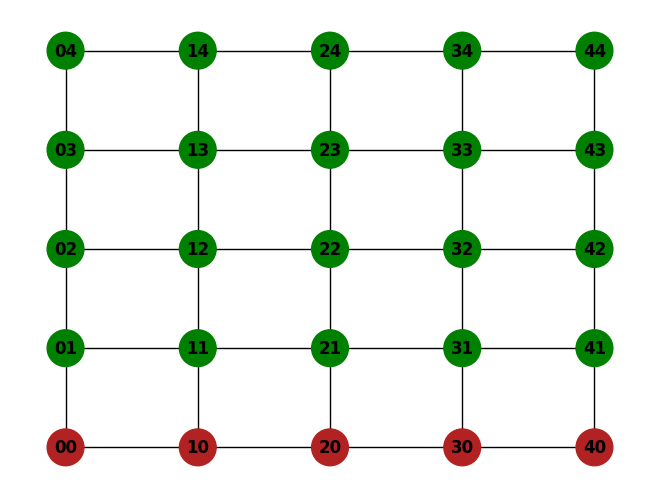

Time 2: Node 00 is freed.
generate communication end: 2
generate communication begin: 2


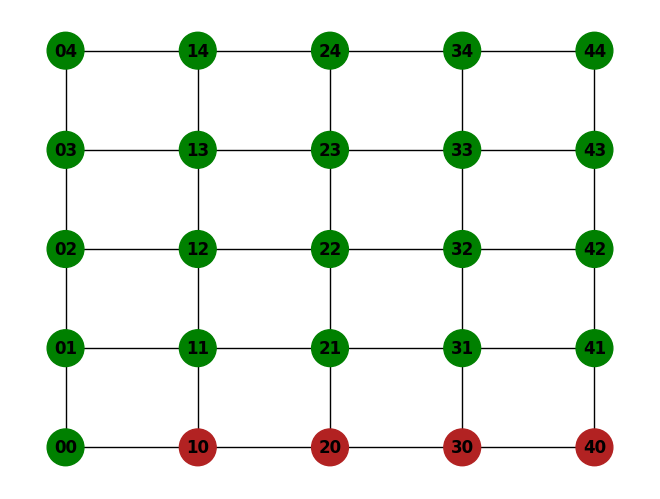

Time 3: Node 10 is freed.
generate communication end: 3
generate communication begin: 3


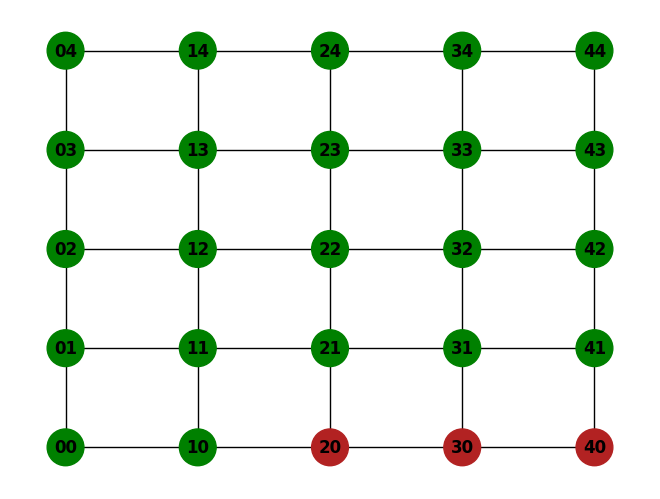

Time 4: Node 20 is freed.
generate communication end: 4
generate communication begin: 4


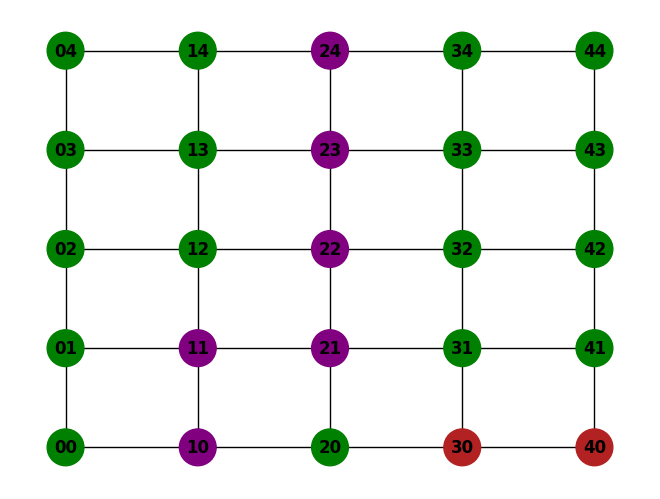

Time 5: Node 10 is freed.
Time 5: Node 30 is freed.
Time 5: Node 40 is freed.
Packet 0 has been delivered along path ['00', '10', '20', '30', '40']
generate communication end: 5
generate communication begin: 5


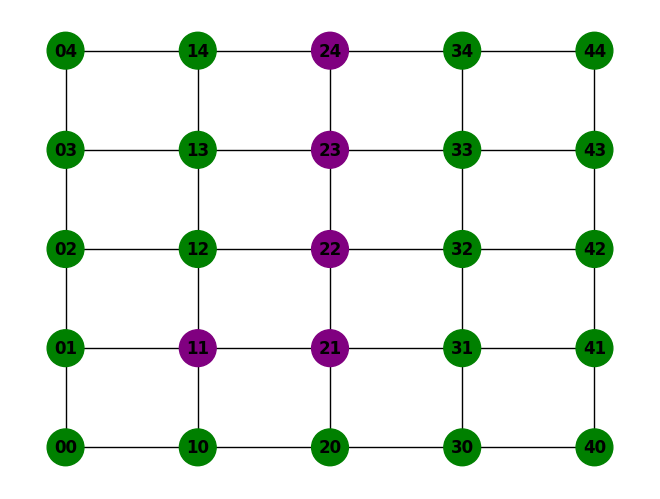

Time 6: Node 11 is freed.
generate communication end: 6
generate communication begin: 6


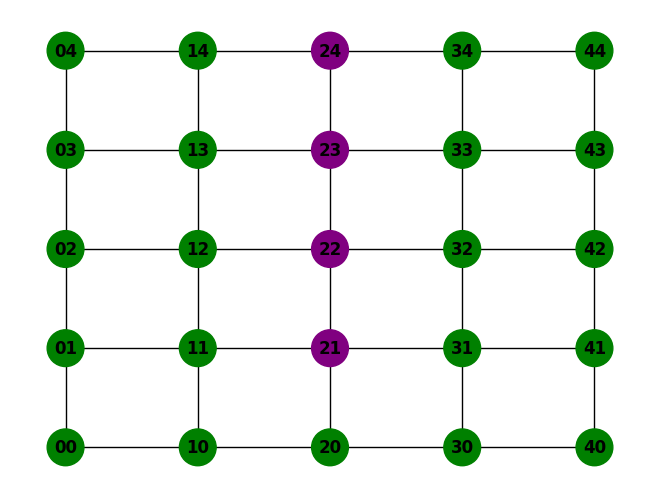

Time 7: Node 21 is freed.
generate communication end: 7
generate communication begin: 7


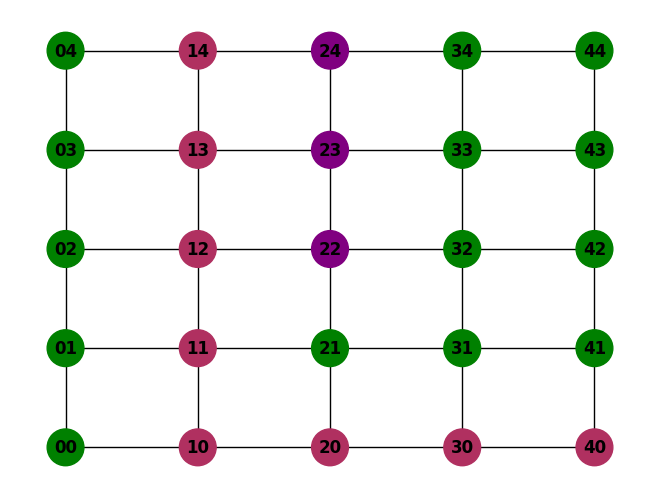

Time 8: Node 40 is freed.
Time 8: Node 22 is freed.
generate communication end: 8
generate communication begin: 8


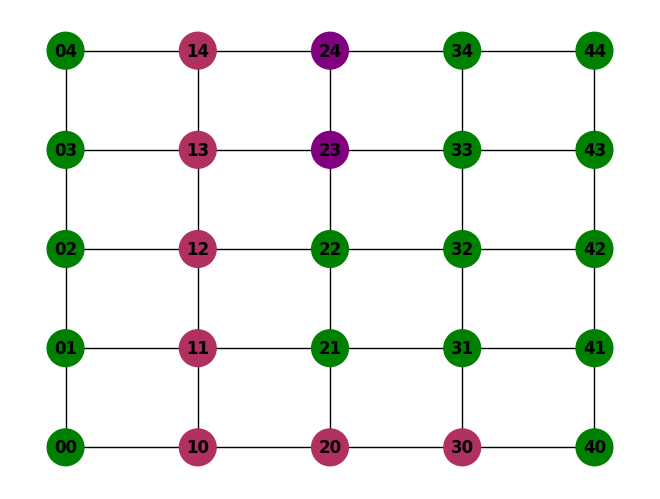

Time 9: Node 30 is freed.
Time 9: Node 23 is freed.
Time 9: Node 24 is freed.
Packet 1 has been delivered along path ['10', '11', '21', '22', '23', '24']
generate communication end: 9
generate communication begin: 9


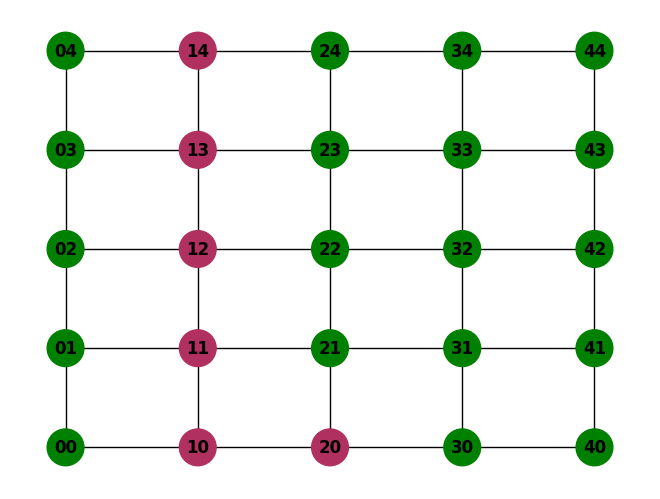

Time 10: Node 20 is freed.
generate communication end: 10
generate communication begin: 10


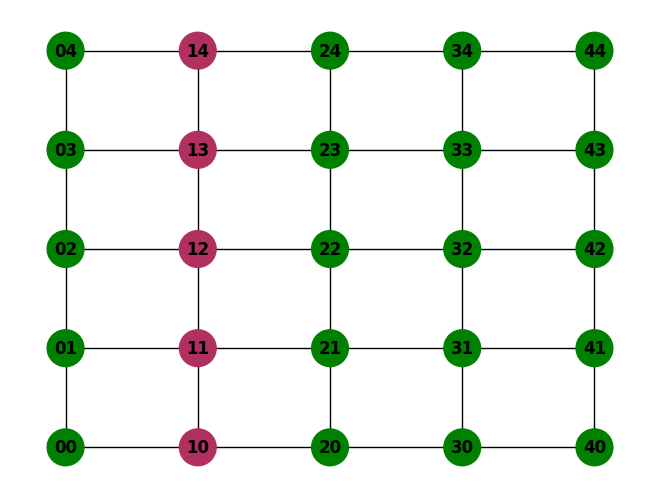

Time 11: Node 10 is freed.
generate communication end: 11
generate communication begin: 11


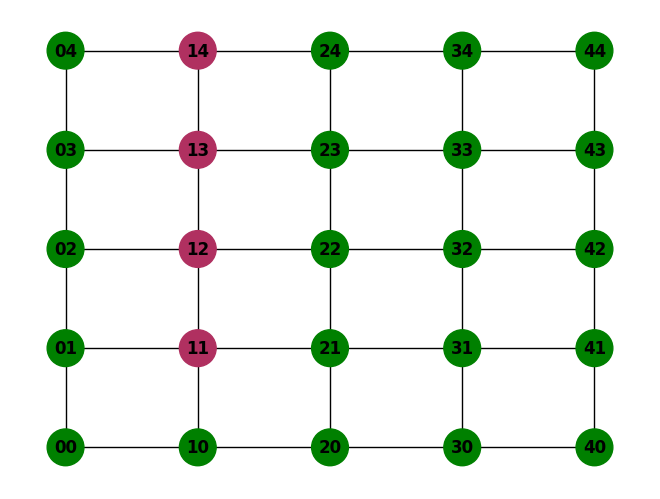

Time 12: Node 11 is freed.
generate communication end: 12
generate communication begin: 12


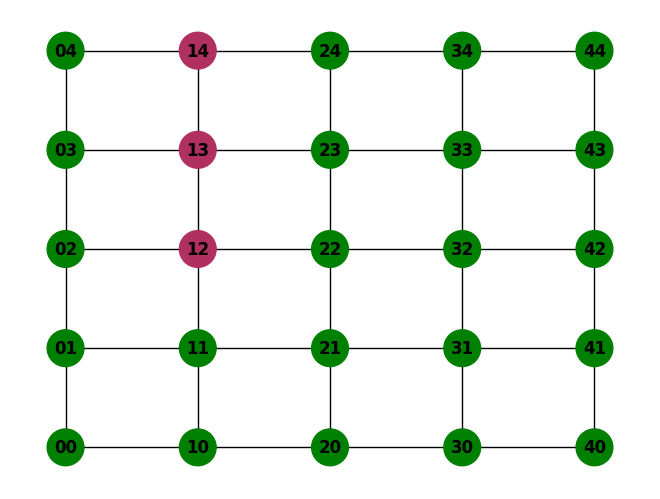

Time 13: Node 12 is freed.
generate communication end: 13
generate communication begin: 13


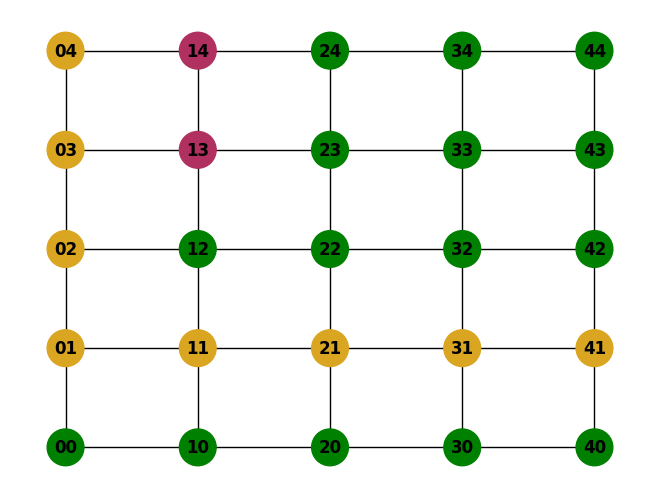

Time 14: Node 04 is freed.
Time 14: Node 13 is freed.
Time 14: Node 14 is freed.
Packet 2 has been delivered along path ['40', '30', '20', '10', '11', '12', '13', '14']
generate communication end: 14
generate communication begin: 14


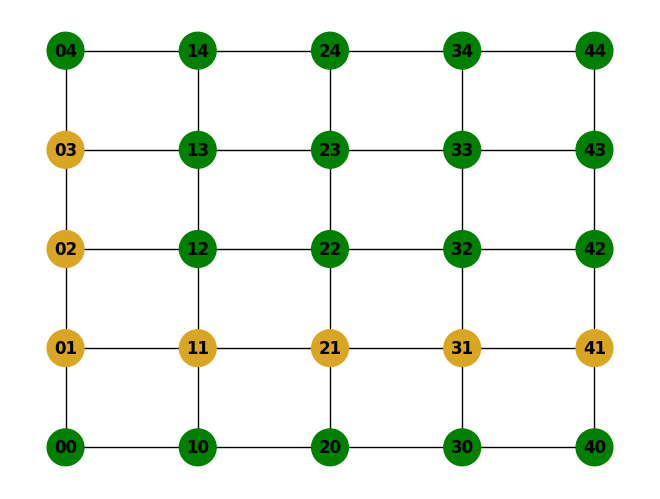

In [13]:
class Grid:
    def __init__(self, grid_size, env):
        self.grid_size = grid_size
        self.env = env  # Store the simulation environment
        self.network = self.create_grid_network()
        self.node_statuses = self.initialize_node_status()

    def create_grid_network(self):
        """
        Create a grid-based network graph with nodes labeled by their coordinates.
        """
        network = nx.Graph()
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                network.add_node(node_label)
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                if x < self.grid_size - 1:
                    right_node = f"{x+1}{y}"
                    network.add_edge(node_label, right_node)
                if y < self.grid_size - 1:
                    below_node = f"{x}{y+1}"
                    network.add_edge(node_label, below_node)
        return network

    def initialize_node_status(self):
        """
        Initialize the status of nodes in the network as 'free'.
        """
        return {node: 'free' for node in self.network.nodes()}

    def plot_network(self, shades_of_red):
        """
        Plot the network with nodes colored based on their status.
        """
        pos = {f"{x}{y}": (x, y) for x in range(self.grid_size) for y in range(self.grid_size)}
        colors = []

        for node in self.network.nodes():
            if self.node_statuses[node] == 'free':
                colors.append('green')
            else:
                colors.append(shades_of_red[self.node_statuses[node]])  # Use the shade assigned to the communication

        nx.draw(self.network, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
        plt.show()

    def is_path_free(self, path):
        """
        Check if all nodes in the path are free.
        """
        return all(self.node_statuses[node] == 'free' for node in path)

    def free_node(self, node):
        """
        Free a single node by marking it as 'free' and print the time it was freed.
        """
        self.node_statuses[node] = 'free'
        print(f"Time {self.env.now}: Node {node} is freed.")

    def reserve_path(self, path, communication_id):
        """
        Reserve the path by marking all nodes as 'busy' with the communication ID.
        """
        for node in path:
            self.node_statuses[node] = communication_id

def communicate(env, grid, source, target, grid_size, communication_queue, communication_id):
    """
    Queue a communication attempt.
    """
    communication_queue.append((env.now, source, target, communication_id))

def communication_manager(env, grid, grid_size, communication_queue, shades_of_red):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            # Sort by start_time to give priority to the longest waiting communication
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]  # Peek at the highest priority task

            all_paths = list(nx.all_shortest_paths(grid.network, source=current_source, target=current_target))
            path_reserved = False

            for path in all_paths:
                if grid.is_path_free(path):
                    communication = Communication(current_id, path, grid)
                    env.process(move_packet(env, communication))  # Start moving the packet
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)  # Only remove the task if the path was successfully reserved

        yield env.timeout(1)  # Wait one time step before processing the next communication

def move_packet(env, communication):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    This process allows multiple packets to move simultaneously in the network.
    """
    while not communication.is_complete():
        communication.advance()
        yield env.timeout(1)  # Each step takes 1 time unit

    communication.complete_communication()

def plot_manager(env, grid, shades_of_red):
    """
    Plot the network at the end of each time step.
    This process ensures that plotting happens after all operations for a time step are completed.
    """
    while True:
        yield env.timeout(1)  # Ensure this process runs after all other processes for the time step
        grid.plot_network(shades_of_red)

# Main execution
grid_size = 5
random.seed(2)

# Create the simulation environment
env = simpy.Environment()

# Create and connect the grid network
grid = Grid(grid_size, env)

# Generate different shades of red for communications
shades_of_red = ["#B22222","#800080", "#B03060", "#DAA520", "#BC8F8F"]

# List to store communication attempts with priority management
communication_queue = []

# Start the communication manager
env.process(communication_manager(env, grid, grid_size, communication_queue, shades_of_red))

# Generate communication attempts in the network between opposite sides
env.process(generate_communications(env, grid, grid_size, communication_queue, shades_of_red))

# Start the plot manager to plot at the end of each time step
env.process(plot_manager(env, grid, shades_of_red))

# Run the simulation
env.run(until=15)  # Run the simulation for 15 time steps


TIME: 1


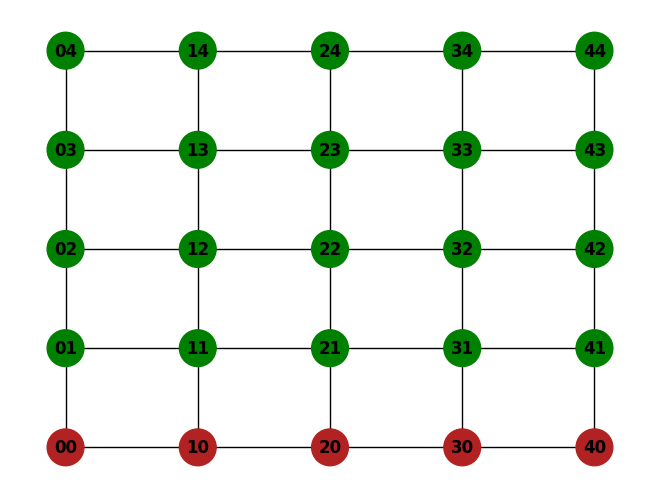

Time 2: Node 00 is freed.
TIME: 2


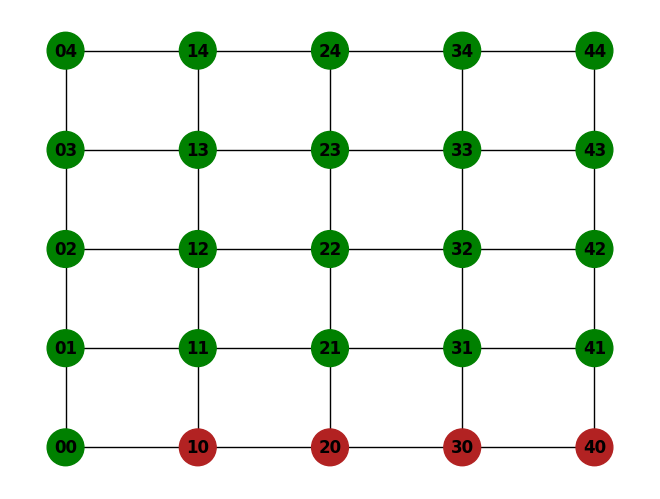

Time 3: Node 10 is freed.
TIME: 3


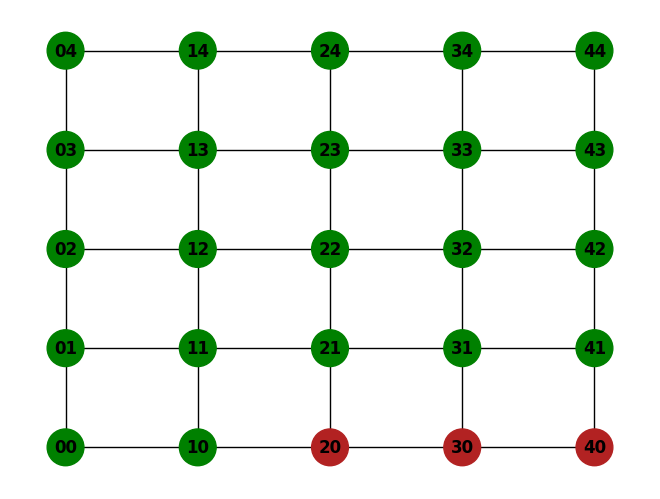

Time 4: Node 20 is freed.
TIME: 4


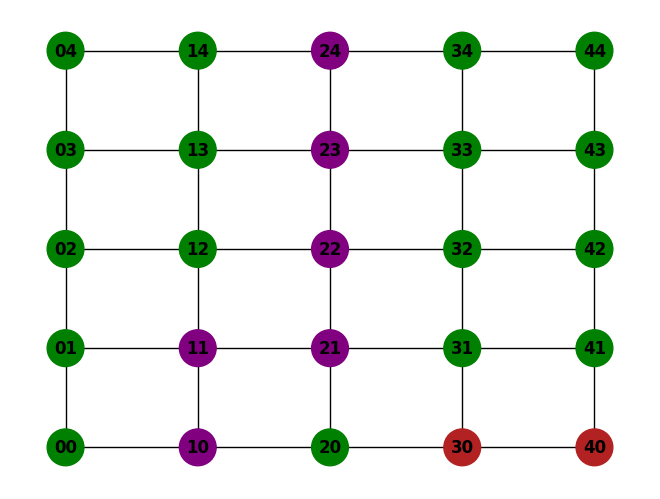

Time 5: Node 10 is freed.
Time 5: Node 30 is freed.
TIME: 5


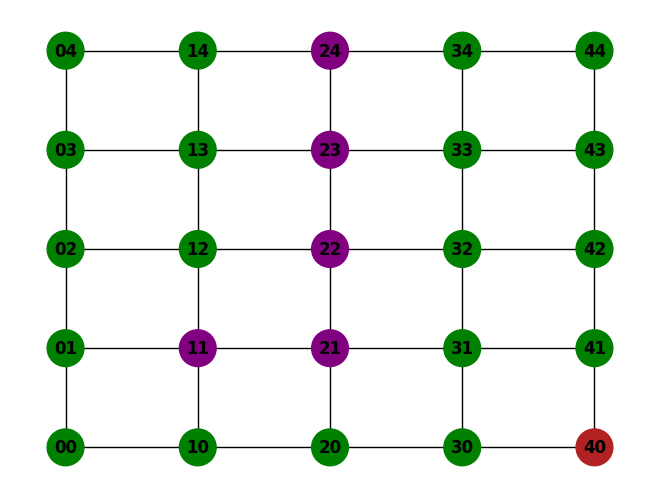

Time 6: Node 11 is freed.
Time 6: Node 40 is freed.
TIME: 6


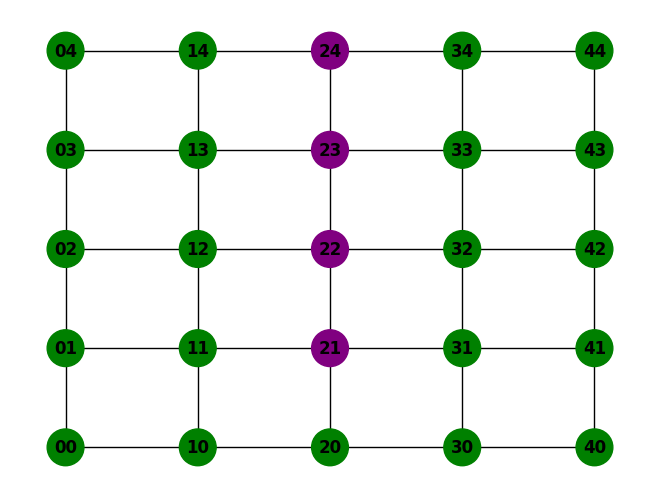

Time 7: Node 21 is freed.
TIME: 7


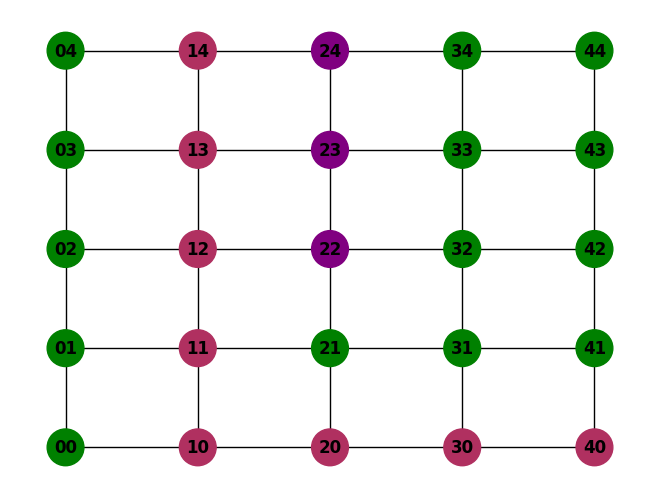

Time 8: Node 40 is freed.
Time 8: Node 22 is freed.
TIME: 8


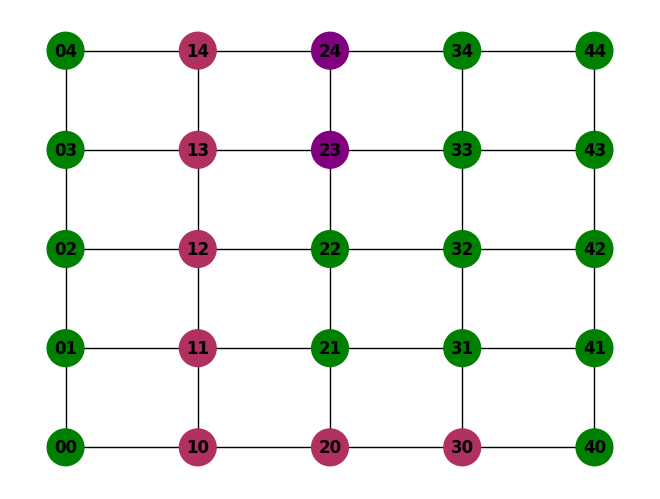

Time 9: Node 30 is freed.
Time 9: Node 23 is freed.
TIME: 9


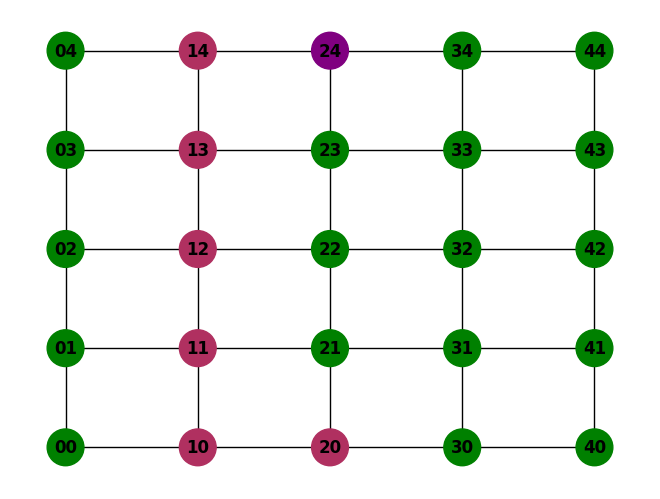

Time 10: Node 20 is freed.
Time 10: Node 24 is freed.
TIME: 10


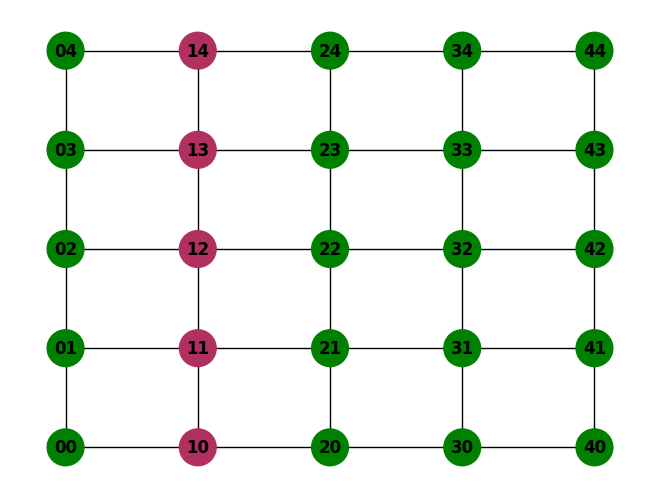

Time 11: Node 10 is freed.
TIME: 11


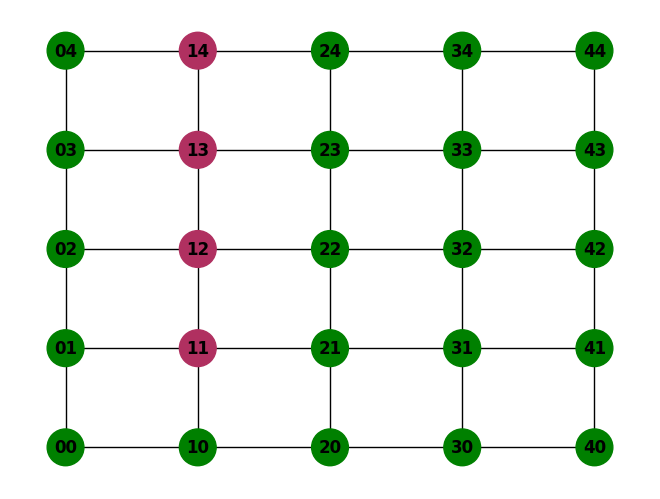

Time 12: Node 11 is freed.
TIME: 12


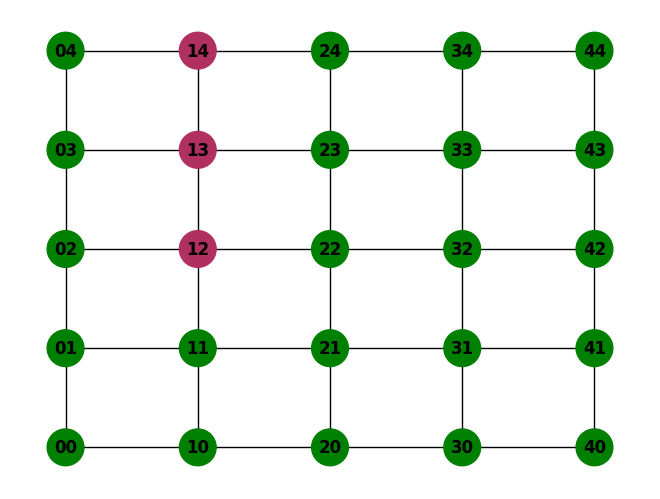

Time 13: Node 12 is freed.
TIME: 13


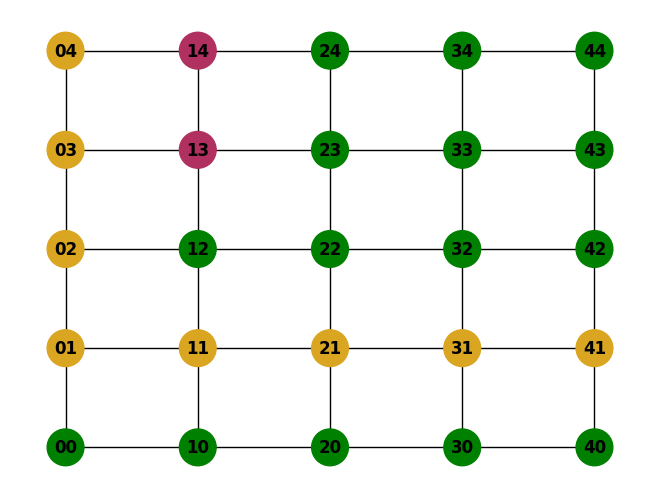

Time 14: Node 04 is freed.
Time 14: Node 13 is freed.
TIME: 14


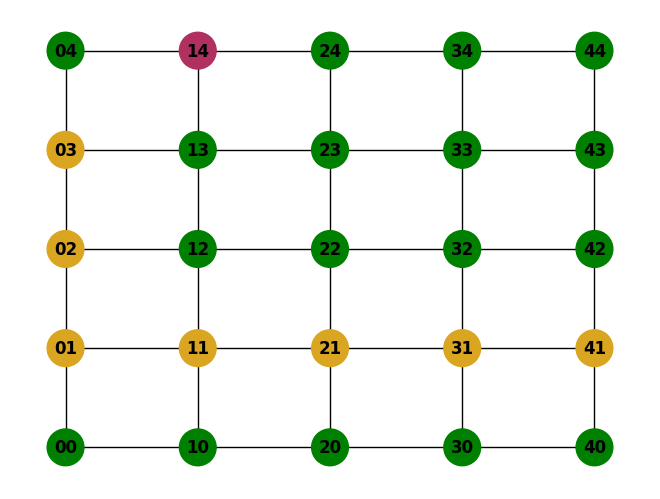

In [3]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt

class Grid:
    def __init__(self, grid_size, env):
        self.grid_size = grid_size
        self.env = env  # Store the simulation environment
        self.network = self.create_grid_network()
        self.node_statuses = self.initialize_node_status()

    def create_grid_network(self):
        """
        Create a grid-based network graph with nodes labeled by their coordinates.
        """
        network = nx.Graph()
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                network.add_node(node_label)
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                if x < self.grid_size - 1:
                    right_node = f"{x+1}{y}"
                    network.add_edge(node_label, right_node)
                if y < self.grid_size - 1:
                    below_node = f"{x}{y+1}"
                    network.add_edge(node_label, below_node)
        return network

    def initialize_node_status(self):
        """
        Initialize the status of nodes in the network as 'free'.
        """
        return {node: 'free' for node in self.network.nodes()}

    def plot_network(self, shades_of_red):
        """
        Plot the network with nodes colored based on their status.
        """
        pos = {f"{x}{y}": (x, y) for x in range(self.grid_size) for y in range(self.grid_size)}
        colors = []

        for node in self.network.nodes():
            if self.node_statuses[node] == 'free':
                colors.append('green')
            else:
                colors.append(shades_of_red[self.node_statuses[node]])  # Use the shade assigned to the communication

        nx.draw(self.network, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
        plt.show()

    def is_path_free(self, path):
        """
        Check if all nodes in the path are free.
        """
        return all(self.node_statuses[node] == 'free' for node in path)

    def free_node(self, node):
        """
        Free a single node by marking it as 'free' and print the time it was freed.
        """
        self.node_statuses[node] = 'free'
        print(f"Time {self.env.now}: Node {node} is freed.")

    def reserve_path(self, path, communication_id):
        """
        Reserve the path by marking all nodes as 'busy' with the communication ID.
        """
        for node in path:
            self.node_statuses[node] = communication_id

class Communication:
    def __init__(self, communication_id, path, grid):
        self.communication_id = communication_id
        self.path = path
        self.current_node_index = 0
        self.time_elapsed = 0
        self.grid = grid
        self.grid.reserve_path(self.path, self.communication_id % len(shades_of_red)) # cycle through shades of red when reserving path

    def advance(self):
        """
        Move the communication to the next node in the path and free the previous node.
        """
        # free the previous node if youre not the first node
        if self.current_node_index > 0:
            previous_node = self.path[self.current_node_index - 1]
            self.grid.free_node(previous_node)

        if not self.is_complete():
            self.current_node_index += 1
            self.time_elapsed += 1

    def is_complete(self):
        """
        Check if the communication has reached its target.
        """
        return self.current_node_index == len(self.path) - 1

    def complete_communication(self, env):
        """
        Free the last node and the second-to-last node after the communication is complete.
        """
        if len(self.path) > 1:
            self.grid.free_node(self.path[-2])
            yield env.timeout(1)
        self.grid.free_node(self.path[-1])


def communication_manager(env, grid, grid_size, communication_queue, shades_of_red):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            # Sort by start_time to give priority to the longest waiting communication
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]  # Peek at the highest priority task

            all_paths = list(nx.all_shortest_paths(grid.network, source=current_source, target=current_target))
            path_reserved = False

            for path in all_paths:
                if grid.is_path_free(path):
                    communication = Communication(current_id, path, grid)
                    env.process(move_packet(env, communication))  # Start moving the packet, calls a function which starts moving packet every one time step
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)  # Only remove the task if the path was successfully reserved

        yield env.timeout(1)  # Wait one time step before processing the next communication

def move_packet(env, communication):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    This process allows multiple packets to move simultaneously in the network.
    """
    while not communication.is_complete():
        communication.advance()
        yield env.timeout(1)  # Each step takes 1 time unit
    yield env.process(communication.complete_communication(env))


def plot_manager(env, grid, shades_of_red):
    """
    Plot the network at the end of each time step.
    Since plot manager is called last when the process managers are being initialised
    it ensures the plots happen at the end of the time step.
    """
    while True:
        yield env.timeout(1)  # plot the system every time step
        print(f"TIME: {env.now}")
        grid.plot_network(shades_of_red)


def generate_communications(env, grid, grid_size, communication_queue, shades_of_red):
    """
    Generate communication attempts between nodes on opposite sides of the grid.
    """
    left_side = [f"0{y}" for y in range(grid_size)]
    right_side = [f"{grid_size-1}{y}" for y in range(grid_size)]
    top_side = [f"{x}0" for x in range(grid_size)]
    bottom_side = [f"{x}{grid_size-1}" for x in range(grid_size)]
    communication_id = 0

    while True:
        # Choose random communication
        if random.choice([True, False]):
            source = random.choice(left_side)
            target = random.choice(right_side)
        else:
            source = random.choice(top_side)
            target = random.choice(bottom_side)

        # Adds communication to queue with the time it was added, source, target and
        # communication id
        communication_queue.append((env.now, source, target, communication_id))

        communication_id += 1
        yield env.timeout(1)  # 1 time step in between communication generations


# Main execution
grid_size = 5
random.seed(2)

# Create the simulation environment
env = simpy.Environment()

# Create and connect the grid network
grid = Grid(grid_size, env)

# Generate different shades of red for communications
shades_of_red = ["#B22222","#800080", "#B03060", "#DAA520", "#BC8F8F"]

# List to store communication attempts with priority management
communication_queue = []

# Start the communication manager
env.process(communication_manager(env, grid, grid_size, communication_queue, shades_of_red))

# Generate communication attempts in the network between opposite sides
env.process(generate_communications(env, grid, grid_size, communication_queue, shades_of_red))

# Start the plot manager to plot at the end of each time step
env.process(plot_manager(env, grid, shades_of_red))

# Run the simulation
env.run(until=15)  # Run the simulation for 15 time steps
